# <font face="Verdana" size=6 color='#6495ED'> IAD-004 APRENDIZAGEM DE MÁQUINA 1
<font face="Verdana" size=3 color='#40E0D0'> Professores Larissa Driemeier e Thiago Martins

<center><img src='https://drive.google.com/uc?export=view&id=1J3dF7v9apzpj27oOsrT8aEagtNIYwq7J' width="600"></center>

O objetivo deste Notebook é fornecer uma descrição fundamental de aprendizado Não supervisionado, abordando conceitos fundamentais e mesclando teoria com códigos em Python. Baseado na aula [IAD-007](https://alunoweb.net/moodle/pluginfile.php/117113/mod_resource/content/6/Aula07_PCA.pdf), ano 2024.


Os seguintes trabalhos foram extremamente importantes na elaboração deste material:
* Clusterização
1. Suraj Yadav, [Silhouette Coefficient Explained with a Practical Example: Assessing Cluster Fit](https://medium.com/@Suraj_Yadav/silhouette-coefficient-explained-with-a-practical-example-assessing-cluster-fit-c0bb3fdef719), 2023.

* PCA
1. [Dimensionality Reduction: Principal Component Analysis in-depth](https://nbviewer.jupyter.org/github/jakevdp/sklearn_pycon2015/blob/master/notebooks/04.1-Dimensionality-PCA.ipynb), de Jake Vanderplas, 2015.
2. [A tutorial on Principal Components Analysis](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf), de Lindsay I Smith, 2002.
3. [Implementing a Principal Component Analysis (PCA)](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html#what-is-a-good-subspace), de Sebastian Raschka, 2014.
4. [A Structural Risk Minimization Approach to Principal Component Analysis](https://colab.research.google.com/github/foxtrotmike/PCA-Tutorial/blob/master/pca.ipynb#scrollTo=isMQxiFkxf_w), de Fayyaz Minhas.
5. [PCA and SVD](https://intoli.com/blog/pca-and-svd/), de Andre Perunicic, 2017.
6. [Principal Component Analysis Made Easy: A Step-by-Step Tutorial](https://towardsdatascience.com/principal-component-analysis-made-easy-a-step-by-step-tutorial-184f295e97fe), de Marcus Sena, 2024.

> <small>*The world doesn't need a yet another PCA tutorial, just like the world doesn't need another silly love song.  But sometimes you still get the urge to write your own.*, Scott H. Hawley, 2019</small>




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from numpy.random import uniform
from sklearn.datasets import make_blobs
import seaborn as sns
import random
from numpy import exp, sqrt, array, abs
sns.set()
import math
from mpl_toolkits import mplot3d


# Aprendizado não supervisionado

A aprendizagem não supervisionada é um conjunto de ferramentas estatísticas para cenários em que existe apenas um conjunto de recursos e nenhum rótulo.
Portanto, não podemos fazer previsões, uma vez que não existem respostas associadas a cada observação. Em vez disso, estamos interessados em encontrar uma forma interessante de visualizar dados ou em descobrir subgrupos de observações semelhantes.

Duas técnicas serão o foco desta aula:  agrupamento (clustering) e análise de componentes principais ou PCA (do inglês, Principal Component Analysis).

# Clusterização por K-means

Um dos algoritmos mais populares e amplamente utilizados para tarefas de cluster é o K-means. Um algoritmo de agrupamento K-means tenta agrupar itens semelhantes na forma de clusters. O número de grupos é representado por K.

O algoritmo iterativo baseado em centróide que cria clusters não sobrepostos.

<center><img src='https://drive.google.com/uc?export=view&id=13ylU4sxfjMKoD72fRtCk0XNXnWH3UvhQ' width="600"></center>


A classe `KMeans` foi adaptada do [link](https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670).

Para um determinado conjunto de dados `X_train`, `n_cluster` é especificado como o número de clusters distintos aos quais os dados pertencem e `max_iter` será o número máximo de iterações para otimizar a clusterização.

Os `n_cluster` centroides são primeiro inicializados aleatoriamente e, em seguida, iterações são realizadas para otimizar as suas localizações da seguinte forma:
* A distância Euclidiana de cada ponto a cada centróide é calculada:
$$
d_{ij} = \sqrt{\left(x_1^{(i)}-c_j\right)^2+\left(x_2^{(i)}-c_j\right)^2+ \cdots +\left(x_n^{(i)}-c_j\right)^2}
$$
 onde $n$ é a dimensão dos dados, $i$ é cada ponto de dado, e $j$ cada centroide.
* Os pontos são atribuídos ao centróide mais próximo.
* Os centróides são deslocados para serem o valor médio dos pontos pertencentes a ele.
* Repete-se o algoritmo até os centróides não se moverem, ouser atingido o número máximo de iterações.

In [3]:
class KMeans:

    def __init__(self, n_clusters=8, max_iter=1000, centroid_init = 'firstRandom'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroid_init = centroid_init

    def _euclidean(self,x,X):
        '''
        Calcula a distância euclidiana entre um ponto de dados x e
        todos os outros pontos no conjunto de dados, denotado como X

        Argumentos:
          x: ponto de dados para o qual as distâncias serão calculadas
          X: o conjunto de dados incluindo todos os pontos de dados
        '''
        return np.sqrt(np.sum((x - X)**2, axis=1))

    def _initialise_centroids(self,data):
        ## 3 ways to initialize centroides
        if(self.centroid_init == 'random'):
            initial_centroids = np.random.permutation(data.shape[0])[:self.n_clusters]
            self.centroids = data[initial_centroids]
        elif(self.centroid_init == 'firstRandom'):
            # Um ponto aleatório dos dados é escolhido para o primeiro centróide
            # então o restante é inicializado com probabilidades proporcionais às suas distâncias até o primeiro
            self.centroids = [random.choice(data)]
            for _ in range(self.n_clusters-1):
                # Calcular distâncias dos pontos aos centróides
                dists = np.sum([self._euclidean(centroid, data) for centroid in self.centroids], axis=0)
                # Normalizar as distâncias
                dists /= np.sum(dists)
                # Escolha os centroides restantes com base em suas distâncias
                # veja que, na linha a seguir, a probabilidade de um ponto ser escolhido é
                # a distância normalizada ao centroide "dists"
                new_centroid_idx = np.random.choice(range(len(data)), p=dists)
                self.centroids += [data[new_centroid_idx]]
        else:
        ## primeiros k valores do dataset
            self.centroids = data[:k]
        return self.centroids

    def fit(self, X_train):
        '''
        Aloca os dados em clusters
        Input : os dados de treinamento (X_train)
        Output: a posição dos centroides (self.centroids) e
        '''
        self._initialise_centroids(X_train)

        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Classificar cada ponto de dados, alocando-o no centroide mais próximo
            sorted_points = [[] for _ in range(self.n_clusters)]
            centroid_idxs = []
            for x in X_train:
                dists = self._euclidean(x,self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)

                centroid_idxs.append(centroid_idx)
            # Atualize centroides prévios
            #  reatribua os centróides como média dos pontos pertencentes a eles
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Capturar qualquer np.nans, resultante de um centroide sem pontos
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
        return self.centroids, sorted_points, centroid_idxs

    def evaluate(self, X_test):
            centroid_idxs = []
            for x in X_test:
                dists = self._euclidean(x,self.centroids)
                centroid_idx = np.argmin(dists)
                centroid_idxs.append(centroid_idx)
            return centroid_idxs


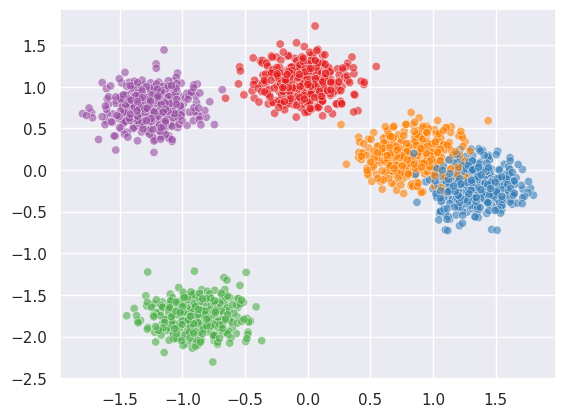

In [4]:
# Dataset
centers = 5
X_train, true_labels_train = make_blobs(n_samples=2000, centers=centers, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue=true_labels_train,
                palette="Set1", alpha = 0.6,
                legend=None
                );


In [5]:
# Ajustar os centroides ao dataset
kmeans = KMeans(n_clusters=centers)
centroids, sorted_points, labels_train = kmeans.fit(X_train)


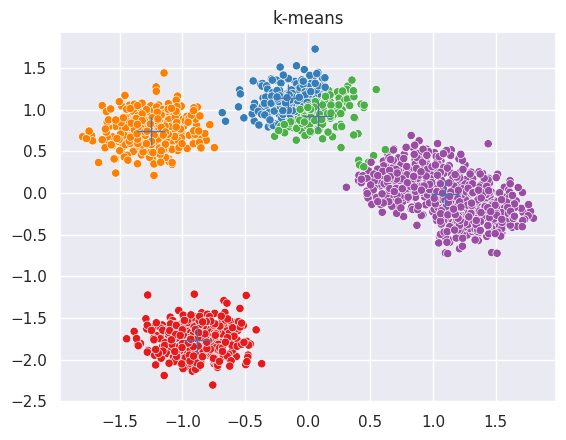

In [6]:
# Ver resultados
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue=labels_train,
                palette="Set1",
                legend=None
                )
plt.plot([x for x, _ in centroids],
         [y for _, y in centroids],
         '+',
         markersize=20,
         )
plt.title("k-means")
plt.show()


E agora, vamos escolher 20 pontos, e tentar classificar.

Para escolher os 20 pontos, geramos de novo os dados artificiais. Porém, desta vez, geramos 30 dados a mais com mesmo `random_state=42` e pegamos somente os últimos 20, que não foram utilizados no treinamento.




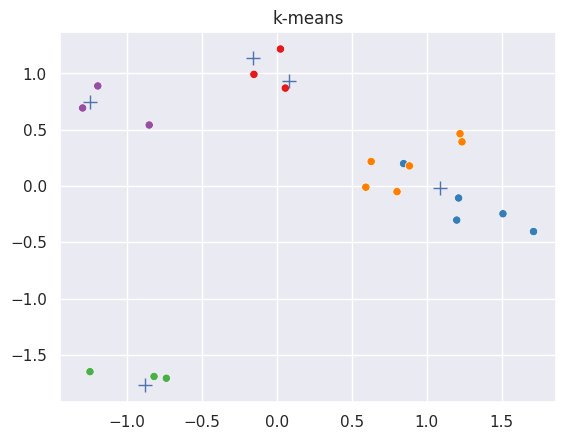

In [7]:
centers = 5
t1, t2 = make_blobs(n_samples=2030, centers=centers, random_state=42)
X_test =t1[-20:]
true_labels_test = t2[-20:]

X_test = scaler.transform(X_test)


# Plotagem dos dados de teste
sns.scatterplot(x=[X[0] for X in X_test],
                y=[X[1] for X in X_test],
                hue=true_labels_test,
                palette="Set1",
                legend = None
                )
plt.plot([x for x, _ in centroids],
         [y for _, y in centroids],
         '+',
         markersize=10,
         )
plt.title("k-means")
plt.show()


Aqui vamos concatenar os dados de treino e teste, simplesmente para plotá-los em um único gráfico.

Para melhor visualização dos dados de teste, usamos somente os 100 primeiros dados de treino.

Veja que foi adicionada uma terceira coluna aos dados, além das coordenadas: a coluna é completada com `1` para dados de teste, que serão plotados com `+`, e com `0` para dados de treino, que serão plotados com `o`.

In [8]:
X_conc = X_train[0:101].copy()
c = [0]*len(X_conc)
X_conc = np.insert(X_conc, 2, c, axis=1)
X1 =  X_test.copy()
c = [1]*len(X1)
X1 = np.insert(X1, 2, c, axis=1)
X_conc = np.insert(X_conc, 0, X1, axis=0)
true_labels_conc = true_labels_train[0:101].copy()
true_labels_conc = np.insert(true_labels_conc, 0, true_labels_test, axis=0)


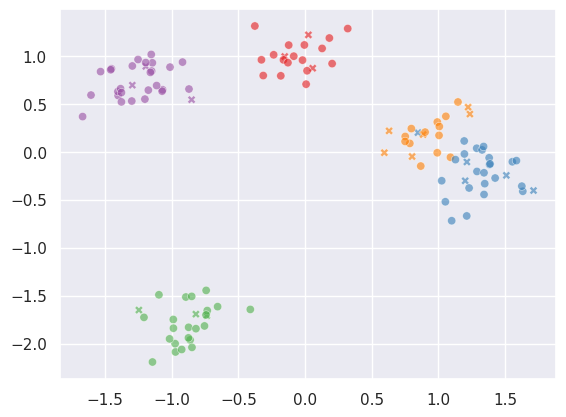

In [9]:
# Plotagem dos dados de treino e teste juntos
sns.scatterplot(x=[X[0] for X in X_conc],
                y=[X[1] for X in X_conc],
                style=X_conc[:,2],
                hue=true_labels_conc,
                palette="Set1", alpha= 0.6,
                legend = None
                );


Agora, vamos usar o método `evaluate` da classe `KMeans` para classificar os dados. Vejamos como será o desempenho de nosso modelo.

In [10]:
labels_test = kmeans.evaluate(X_test)


Agora vamos plotar nosso gráfico novamente. Porém, ao invés de usar o `true_labels_test` (que, na verdade, não teríamos em uma situação real), e vamos usar o resultado do nosso modelo. Para isso, temos que reescrever o vetor de labels:

In [11]:
labels_conc = labels_train[0:101].copy()
labels_conc = np.insert(labels_conc, 0, labels_test, axis=0)


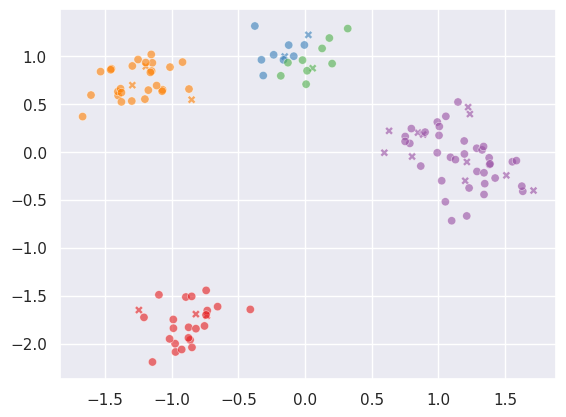

In [12]:
# Plotagem dos dados de treino e teste juntos
sns.scatterplot(x=[X[0] for X in X_conc],
                y=[X[1] for X in X_conc],
                style=X_conc[:,2],
                hue=labels_conc,
                palette="Set1", alpha = 0.6,
                legend = None
                );


## Escolha do hiperparâmetro $K$

Os dados com os quais você trabalhará nem sempre terão demarcações distintas quando plotados. Aliás, muitas vezes, você lidará com dados de dimensões altas, que não podem ser plotados. Ou mesmo que sejam plotados, você não poderá determinar o número ótimo de agrupamentos.

Os métodos do cotovelo e da silhueta são técnicas usadas para determinar o número ótimo de clusters em um algoritmo de agrupamento como o K-means.




### Método cotovelo

A Soma das Quadrados Dentro do Agrupamento (WCSS, do inglês Within-Cluster Sum of Squares) é uma medida utilizada na análise de agrupamentos (clustering) para quantificar a variabilidade dos pontos de dados dentro de cada cluster. Em outras palavras, WCSS calcula a soma dos quadrados das distâncias de cada ponto de dados ao centróide do seu respectivo cluster,
$$
\text{WCSS} = \sum_{i=1}^{k} \sum_{\textbf{x}_j \in C_i} \| \textbf{x}_j - \boldsymbol{\mu}_i \|^2
$$

<center><img src='https://drive.google.com/uc?export=view&id=1bJlQd1mMjHLrCTS2_caJQzVQ4u10XejE' width="400"></center>

Onde:

* $k$ é o número de clusters,
* $C_i$ é o $i$-ésimo cluster,
* $\textbf{x}_j=\begin{bmatrix}x_{j} & y_{j}\end{bmatrix}^T$ é o $j$-ésimo ponto de dados,
* $ \boldsymbol{\mu}_i =\begin{bmatrix}x_{C_i} & y_{C_i}\end{bmatrix}^T$ é o centróide do $i$-ésimo cluster,
* $\| \textbf{x}_j - \boldsymbol{\mu}_i \|^2$ é a distância quadrada entre o ponto de dados $\textbf{x}_j$ e o centróide $ \boldsymbol{\mu}_i$.


Quanto menor for o valor do WCSS, mais compactos e coesos são os clusters.

In [13]:
def calculate_wcss(data, labels, centroids,k):
   """
   Calcula WCSS para diferentes valores de K no agrupamento K-means.
   Parâmetros:
   dados (array): os dados a serem agrupados.
   max_k (int): O número máximo de clusters a serem testados.
   Retorna:
   valor WCSS para K
   """
   wcss = 0
   for i in range(k):
        cluster_points = data[i]
        wcss += np.sum((cluster_points - centroids[i]) ** 2)
   return wcss


In [14]:
# Dataset
centers = 5
X_train, true_labels_train = make_blobs(n_samples=2000, centers=centers, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


/home/codespace/.local/share/virtualenvs/POLI-uUrlVJ__/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/.local/share/virtualenvs/POLI-uUrlVJ__/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


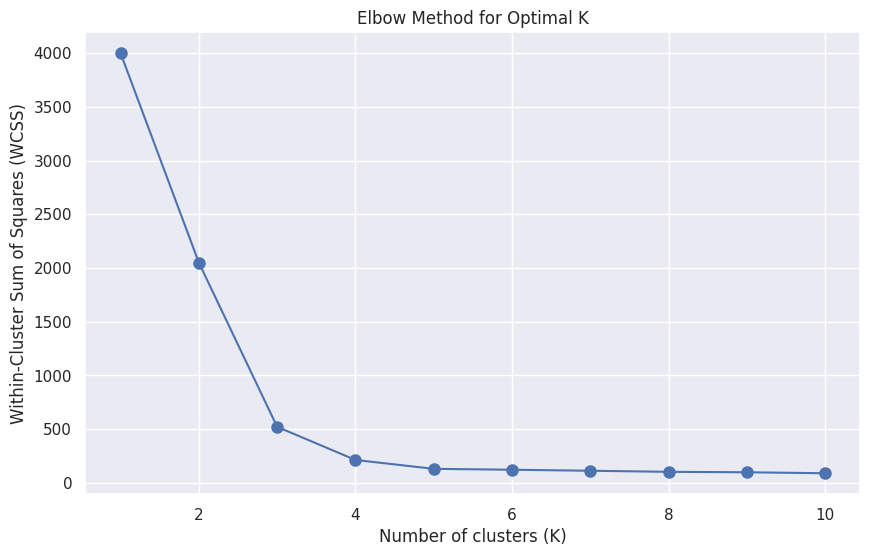

In [15]:
# Faixa de valores de K
K_range = range(1, 11)

# Lista para armazenar os valores WCSS para cada K
wcss = []

# Cálculo de WCSS de cada K
wcss_values = []
for k in K_range:
   kmeans = KMeans(n_clusters=k)
   centroids, sorted_points, labels = kmeans.fit(X_train)
   wcss = calculate_wcss(sorted_points, labels, centroids,k)
   wcss_values.append(wcss)

# Plotagem do gráfico
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss_values, 'bo-', markersize=8)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


Veja que, a partir de $K=3,4,5$ não há significante mudança na variação dos dados dentro dos clusters.

### Método Silhueta

O método da silhueta mede a similaridade e a dissimilaridade dos pontos de dados dentro dos clusters e entre clusters, respectivamente. A ideia é encontrar um número de clusters que maximize a similaridade dentro dos clusters e minimize a similaridade entre clusters.

<center><img src='https://drive.google.com/uc?export=view&id=1Z7TBDT6vbowbAUQITIb9zEAjo5Zd-aqd' width="800"></center>

__1. Cálculo da Similaridade Intra-cluster__

Para cada ponto $i$ em um cluster, calcula-se a média das distâncias entre $i$ e todos os outros pontos no mesmo cluster. Essa medida é conhecida como $a(i)$:
$$
a(i) = \frac{1}{|C| - 1} \sum_{j \in C, j \neq i} d(i, j)
$$
onde $|C|$ é o número de pontos no cluster $C$ e $d(i, j)$ é a distância entre os pontos $i$ e $j$.

__2. Cálculo da Dissimilaridade Inter-cluster__

Para cada ponto $i$, calcula-se a média das distâncias entre $i$ e todos os pontos no cluster mais próximo ao qual $i$ não pertence. Essa medida é conhecida como $b(i)$:
$$
b(i) = \min_{k \neq C} \frac{1}{|C_k|} \sum_{j \in C_k} d(i, j)
$$
onde $C_k$ é um cluster diferente do cluster $C$ ao qual o ponto $i$ pertence.

__3. Cálculo do Coeficiente de Silhueta__

Para cada ponto $i$, o coeficiente de silhueta é dado por:
$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$
O valor de $s(i)$ varia entre -1 e 1. Um valor próximo de 1 indica que o ponto está bem agrupado, enquanto um valor próximo de -1 indica que o ponto pode estar no cluster errado.

__4. Cálculo da Média do Coeficiente de Silhueta__

A média dos coeficientes de silhueta para todos os pontos em um cluster dá uma medida da qualidade do agrupamento. A média dos coeficientes de silhueta para todos os pontos no conjunto de dados dá uma medida global da qualidade do agrupamento:
$$
\bar{s} = \frac{1}{N} \sum_{i=1}^{N} s(i)
$$
onde $N$ é o número total de pontos no conjunto de dados.

__5. Escolha do Número Ótimo de Clusters__

O número ótimo de clusters é aquele que maximiza a média dos coeficientes de silhueta. Em outras palavras, é o número de clusters que resulta na maior média de similaridade intra-cluster e dissimilaridade inter-cluster.

Um coeficiente de silhueta de 1 denota que o ponto de dados está bem  *compactado*  do cluster ao qual pertence e distante dos outros clusters. O pior valor é -1. Valores próximos a 0 denotam clusters sobrepostos.

In [16]:
def euclidean_distance(point1, point2):
    '''
    Calcular a distância euclidiana entre dois pontos
    INPUT: pontos (point2 e point2) e vetor com todos os pontos do cluster (cluster_points)
    OUTPUT: distância Euclidiana entre point1 e point2
    '''
    return np.sqrt(np.sum((point1 - point2) ** 2))


def mean_intra_cluster_distance(point, cluster_points):
    '''
    Calcular a média da distância entre um ponto e todos os pontos em um cluster
    INPUT: ponto (point) e vetor com todos os pontos do cluster (cluster_points)
    OUTPUT: média entre a distância do "point" e dos demais "cluster_points"
    '''
    return np.mean([euclidean_distance(point, other) for other in cluster_points if not np.array_equal(point, other)])


def mean_nearest_cluster_distance(point, point_cluster, clusters):
    '''
    Calcular a média da distância entre um ponto e todos os pontos do cluster mais próximo
    INPUT: ponto (point), vetor com todos os pontos do cluster (cluster_points) e demais clusters (clusters)
    OUTPUT: média entre a distância do "point" e dos pontos do cluster mais próximo
    '''
    distances = []
    for cluster_label, cluster_points in clusters.items():
        if cluster_label != point_cluster:
            distances.append(np.mean([euclidean_distance(point, other) for other in cluster_points]))
    return np.min(distances)

def silhouette_coefficient(point, point_cluster, clusters):
    '''
    Calcular a,b, e o coeficiente de silhueta de um ponto
    INPUT: ponto (point), vetor com todos os pontos do cluster (cluster_points) e demais clusters (clusters)
    OUTPUT: (b-a)/max(a,b)
    '''
    a = mean_intra_cluster_distance(point, clusters[point_cluster])
    b = mean_nearest_cluster_distance(point, point_cluster, clusters)
    return (b - a) / max(a, b)

def silhouette_score(data, labels):
    '''
    Calcular a média dos coeficientes de silhueta para todos os pontos
    INPUT: dados (data) e o cluster a que pertence cada dado (labels)
    OUTPUT: média de todos valores de (b-a)/max(a,b) e score de cada ponto, em cada cluster
    '''
    unique_labels = np.unique(labels)
    clusters = {label: data[label] for label in unique_labels}

    silhouette_scores = []
    for label in unique_labels:
        for point in clusters[label]:
            silhouette_scores.append([label,silhouette_coefficient(point, label, clusters)])

    return np.mean(silhouette_scores,axis=0), silhouette_scores


In [17]:
# Dataset
centers = 5
X_train, true_labels_train = make_blobs(n_samples=2000, centers=centers, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [18]:
# Faixa de valores de K
K_range = range(2, 8)

# Lista para armazenar os valores SILHUETA para cada K
silhouette = []

# Calcular Silhueta para cada K
silhouette_values = []
silhouette_profile = []
for k in K_range:
   kmeans = KMeans(n_clusters=k)
   centroids, sorted_points, labels = kmeans.fit(X_train)
   silhouette, silhouette_scores = silhouette_score(sorted_points,labels)
   silhouette_values.append(silhouette[1])
   silhouette_profile.append([k,silhouette_scores])

# Calculando o coeficiente de silhueta
print(f"Silhueta: {silhouette_values}")


Silhueta: [0.46927260319569164, 0.7015912557233602, 0.5717499881532021, 0.4511101231432419, 0.510705863103795, 0.4969081436349353]


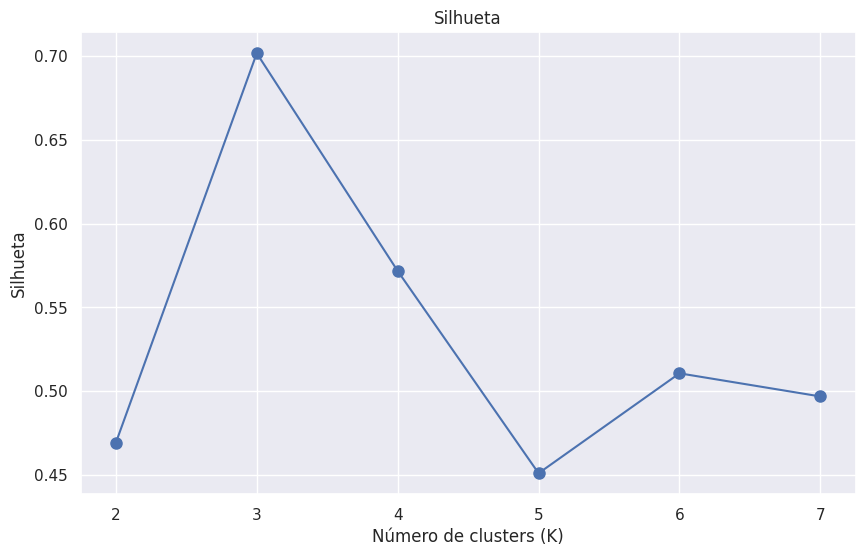

In [19]:
# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_values, 'bo-', markersize=8)
plt.xlabel('Número de clusters (K)')
plt.ylabel('Silhueta')
plt.title('Silhueta')
plt.grid(True)
plt.show()


Veja que uma plotagem comum da silhueta é o perfil de cada nó para cada número de clusters $k$, conforme ilustra a figura abaixo.

<center><img src='https://drive.google.com/uc?export=view&id=1b2E98m5jiwEUj48rP61ACHqAuvuibqaz' width="600"></center>

<small> Figura extraída do [link](https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html) <small>

`silhouette_profile[0][0]` armazena o número de clusters da análise, enquanto `silhouette_profile[0][1]` armazena o número do label (`silhouette_profile[0][1][i][0]`) e o valor da silhueta (`silhouette_profile[0][1][i][1]`) de cada ponto $i$.

In [20]:
silhouette_profile[1][1][1999][1]


0.4957473903485653

In [21]:
silhouette_profile[1][1]


[[0, 0.8595285893055702],
 [0, 0.8976513810111413],
 [0, 0.8875727732502108],
 [0, 0.8297406036507093],
 [0, 0.896484811121725],
 [0, 0.9152935752892523],
 [0, 0.7692759479110677],
 [0, 0.8689335817480417],
 [0, 0.860152703214939],
 [0, 0.8281022630725237],
 [0, 0.8881694400420543],
 [0, 0.8376596701842306],
 [0, 0.8679953406321438],
 [0, 0.910251895726116],
 [0, 0.8935712846110577],
 [0, 0.8764714355842295],
 [0, 0.8800417465125154],
 [0, 0.9021373707784128],
 [0, 0.903675674514084],
 [0, 0.9097224432906351],
 [0, 0.9110313674412709],
 [0, 0.8645388827122283],
 [0, 0.8795662404642871],
 [0, 0.9035083232178212],
 [0, 0.7581104545972145],
 [0, 0.890827531069079],
 [0, 0.9117407063643731],
 [0, 0.9039464077588142],
 [0, 0.8960523240189774],
 [0, 0.8404851827665841],
 [0, 0.903480442493091],
 [0, 0.9142638069366898],
 [0, 0.913874133439157],
 [0, 0.8654661561963046],
 [0, 0.9077698653534831],
 [0, 0.9164477892134425],
 [0, 0.8704501183137836],
 [0, 0.8987455823797585],
 [0, 0.906115361060

Parece que 4 clusters é uma boa ideia....

In [22]:
dim_sil = np.array([silhouette_profile[0][1][i][1] for i in range(len(silhouette_profile[0][1]))])
print(dim_sil.shape)


(2000,)


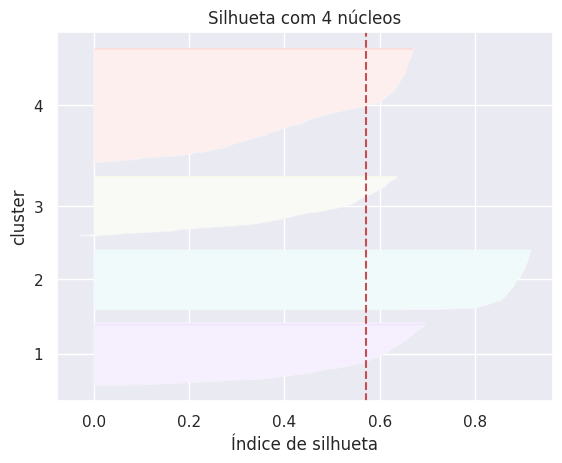

In [23]:
k= 4
index_k = range(2,8).index(k)
colors = ['DarkOliveGreen', 'steelblue']
colors = cm.rainbow(np.linspace(0, 1, k))
sil={}
y = {}
for i in range(k):
    sil[i] = []
for i in range(len(silhouette_profile[0][1])):
    sil[silhouette_profile[index_k][1][i][0]].append(silhouette_profile[index_k][1][i][1])
l = 0
for i in range(k):
     y[i] = [j for j in range(l,len(sil[i])+l)]
     l += 1

fig, ax = plt.subplots()
width = 1. # the width of the bars
tot = 0
space = 100
tpos = []
tlabels = []
siltot = 0
n = 0
for j in range(k):
  ax.barh(np.array(y[j])+tot, np.sort(sil[j]), width, color=colors[j], alpha = 0.6)
  siltot += sum(sil[j])
  n += len(y[j])
  tpos.append(tot + len(y[j])/2)
  tlabels.append(str(j+1))
  tot += len(y[j]) + space
plt.axvline(siltot/n, 0,tot, linestyle="--", color="r")

ax.set_yticks(tpos)
ax.set_yticklabels(tlabels, minor=False)
plt.title('Silhueta com {:d} núcleos'.format(k))
plt.xlabel('Índice de silhueta')
plt.ylabel('cluster')
plt.show()


#  Clusterização por MeanShift

O modelo de clusterização *mean-shift* atua *deslocando a média* de um conjunto de pontos no espaço de características até convergir para uma região densa, chamada de modo (do inglês, *mode*). __Cada modo encontrado pelo algoritmo é considerado um cluster.__ O algoritmo é baseado na ideia de estimativa de densidade de kernel, que é uma maneira de estimar a função de densidade de probabilidade de um conjunto de dados.

O modelo de estimativa de densidade de kernel 1D (KDE) usa a função:
$$
p(x^i) = \frac{1}{n} \sum_{j=1}^{n} k_\sigma (x^i-x^j)
$$
onde $k_\sigma$ refere-se ao modelo de kernel $k$ com hiperparâmetro (largura de banda) $\sigma$.
A primeira etapa do algoritmo mean-shift é definir hiperparâmetros, que se resumem a:

1. o raio de atuação do kernel, para definir a *região local* de análise;
2. uma função kernel, que é usada para calcular a densidade de probabilidade dos pontos de dados. Uma escolha comum para a função kernel é a função Gaussiana, embora outros tipos de kernels também possam ser utilizados.

A próxima etapa é inicializar a média dos pontos de dados da região local e iniciar o processo iterativo de deslocar a média em direção às regiões densas do conjunto de dados.

A cada iteração, o algoritmo calcula a densidade de probabilidade dos pontos de dados dada a média atual. Em seguida, a média é deslocada para a média ponderada dos pontos de dados, onde os pesos são determinados pela densidade de probabilidade. Esse processo é repetido até que a média convirja ou até que seja alcançado um número máximo de iterações. A média final é atribuída a um cluster, e os pontos de dados mais próximos da média são atribuídos a esse cluster também.

<center><img src='https://drive.google.com/uc?export=view&id=1Vav1AEjV7ysS21jz9utUgDQuG9xJyXaf' width="800"></center>

Uma vez que todos os clusters foram encontrados, o algoritmo pode ser usado para classificar novos pontos de dados atribuindo-os ao cluster mais próximo. O algoritmo mean-shift é particularmente robusto para conjunto de dados contém clusters de diferentes formas e tamanhos. Além disso, o algoritmo mean-shift não requer que o número de clusters seja especificado com antecedência, tornando-o mais flexível para aprendizado de máquina não supervisionado.

### Algoritmo

O algoritmo propõe o uso de dois kernels:
- *Gaussian*, onde é adicionado o hiperparâmetro largura de banda (desvio padrão) $\sigma$:
$$
k_\sigma(d) = \frac{1}{\sigma \sqrt{2 \pi}} exp (- \frac{d^2}{\sigma^2})
$$
$d$ é a distância entre os pontos $(\mathbf x^i- \mathbf x^j)$.

- *Flat*:
$$
k_\sigma(d) =
\begin{align}
 & 1 \text{ se  } d\leq \sigma \\
 &  0 \text{ se  } d> \sigma
\end{align}
$$

In [24]:
class MeanShift(object):
    '''
    Implementação do algoritmo MeanShift com um kernel gaussiano
    link: https://christianmaxmike.github.io/mindnotes/ml-clustering-meanshift
    Argumentos (propriedades):
      max_iter: número máximo de iterações
      bandwidth: desvio padrão do kernel gaussiano
      tol: limite de tolerância
    '''

    def __init__(self, max_iter=100, bandwidth=.3, tol=1e-4):
        self.max_iter = max_iter
        self.bandwidth = bandwidth
        self.tol = tol

    def _euclidean(self, x, X):
        '''
        Calcula a distância euclidiana entre um ponto de dados x e
        todos os outros pontos no conjunto de dados, denotado como X

        INPUT:
          x: ponto de dados para o qual as distâncias serão calculadas
          X: o conjunto de dados incluindo todos os pontos de dados
        '''
        return (sqrt(((x-X)**2).sum(1)))

    def gaussian_kernel(self, d, bandwidth):
        '''
        Define o kernel gaussiano

        INPUT:
          d: distância
          bandwidth: largura de banda que define o desvio padrão do kernel gaussiano
        '''
        f_1 = 1.0/(bandwidth * math.sqrt(2*math.pi))
        f_2 = exp(-0.5*((d/bandwidth))**2)
        return f_1 * f_2

    def R_kernel(self, d, R):
        '''
        Define o kernel gaussiano

        INPUT:
          d: distância
          bandwidth: largura de banda que define o desvio padrão do kernel gaussiano
        '''
        range_R = []
        for i in range(len(d)):
          if d[i] <= R:
            range_R.append(1)
          else:
            range_R.append(0)
        return np.array(range_R)

    def _calc (self, x, X, bandwidth):
        '''
        Calcula a média ponderada de todos os pontos de dados em X com relação a um certo ponto de dados x em X.

        INPUT:
          x: ponto de dados sendo atualmente considerado
          X: conjunto de dados
          bandwidth: largura de banda para o kernel "Gaussian" (fator de suavização) ou raio para o kernel "Flat"
        '''
        # soma ponderada de todos os pontos, cujo peso é dado pela respectiva distância
        # de cada ponto local em relação ao ponto x
        dist = self._euclidean(x, X)
        if self.kernel == 'Gaussian':
          weight = self.gaussian_kernel(dist, bandwidth)
        else:
          if self.kernel == 'Flat':
            weight = self.R_kernel(dist, bandwidth)
          else:
            raise ValueError('Kernel não suportado')
        # soma ponderada de todos os pontos, cujo peso é dado pela respectiva distância
        # de cada ponto em relação ao ponto x
        return (weight[:, None]*X).sum(0) / weight.sum()
        # weight[:, None] é uma forma comum de manipular a forma de um array no NumPy
        # weight é inicialmente um array 1D com forma (3,), o que significa que ele tem 3 elementos.
        # weight[:, None] muda sua forma para (3, 1), o que significa que agora ele tem 3 linhas e 1 coluna.

    def fit (self, X, kernel = 'Gaussian'):
        '''
        Executa o algoritmo MeanShift.

        INPUT:
          X: conjunto de dados
        '''
        it = 0
        self.kernel = kernel
        for i in range(self.max_iter):
            X_adapted = np.array([self._calc(x,X,self.bandwidth) for x in X])
            if it % 1 == 0:
                self._plot(X_adapted)
            if it >= self.max_iter or abs(X-X_adapted).sum()/abs(X.sum()) < self.tol:
                print ("Convergência na iteração {}".format(it))
                self._plot(X_adapted)
                return X_adapted
            X = X_adapted
            it += 1

    def _plot (self, X):
        '''
        Plotagem simples
        '''
        dist = self._euclidean([0,0], X)
        plt.figure()
        plt.scatter(X[:,0], X[:, 1], c=dist, cmap='viridis')
        plt.show()


## Exemplo de Mean Shift com 5 pontos


Abaixo é ilustrado o processo de MEan Shift passo a passo para o conjunto de pontos $\mathbf{X} = \{(1, 2), (2, 3), (3, 4), (6, 8), (7, 9)\}$, considerando a largura de banda $h = 3$.

1. __Inicialize os pontos:__
$\mathbf{X} = \{(1, 2), (2, 3), (3, 4), (6, 8), (7, 9)\}$\;

2. __Escolha uma largura de banda:__
Suponha uma largura de banda $h$ (raio para a vizinhança), digamos $h = 3$.

3. __Iterações para cada ponto:__

<center><img src='https://drive.google.com/uc?export=view&id=1gN_Z50euKE3WPZCDwPFPnPS5NMDx3BD-' width="800"></center>

* Para o ponto $(1, 2)$:
 * Pontos dentro da largura de banda $h = 3$ são $(1, 2), (2, 3), (3, 4)$. Portanto, tem-se a média de:
 $$\left( \frac{1+2+3}{3}, \frac{2+3+4}{3} \right) = (2, 3)$$



 * Para o ponto $(2, 3)$:
 * Pontos dentro da largura de banda $h = 3$ são $(1, 2), (2, 3), (3, 4)$.Portanto, tem-se a média de:
 $$\left( \frac{1+2+3}{3}, \frac{2+3+4}{3} \right) = (2, 3)$$


* Para o ponto $(3, 4)$:
 * Pontos dentro da largura de banda $h = 3$ são $(1, 2), (2, 3), (3, 4)$. Portanto, tem-se a média de:
 $$\left( \frac{1+2+3}{3}, \frac{2+3+4}{3} \right) = (2, 3)$$


* Para o ponto $(6, 8)$:
 * Pontos dentro da largura de banda $h = 3$ são $(6, 8), (7, 9)$. Portanto, tem-se a média de:
 $$\left( \frac{6+7}{2}, \frac{8+9}{2} \right) = (6.5, 8.5)$$


* Para o ponto $(7, 9)$:
 * Pontos dentro da largura de banda $h = 3$ são $(6, 8), $(7, 9)$. Portanto, tem-se a média de:
 $$\left( \frac{6+7}{2}, \frac{8+9}{2} \right) = (6.5, 8.5)$$


4. __Atualize os pontos:__
$$\mathbf{X}_{\text{novo}} = \{(2, 3), (2, 3), (2, 3), (6.5, 8.5), (6.5, 8.5)\}$$

Repita as iterações de Mean Shift até que os pontos parem de mudar significativamente. No caso de nosso exemplo, os pontos já atingiram o equilíbrio:
<center><img src='https://drive.google.com/uc?export=view&id=1Nksf-6M7PkuUjSE2CE8Ja8MjgZ-Xto93' width="200"></center>

Atribua clusters com base nos pontos convergidos\;

Clusters finais:
* __Cluster 1__: $(1, 2), (2, 3), (3, 4)$
* __Cluster 2__: $(6, 8), (7, 9)$

O algoritmo, ao final, terá todos os pontos com coordenadas de seu centroide:
```
[[2.  3. ]
 [2.  3. ]
 [2.  3. ]
 [6.5 8.5]
 [6.5 8.5]]
```



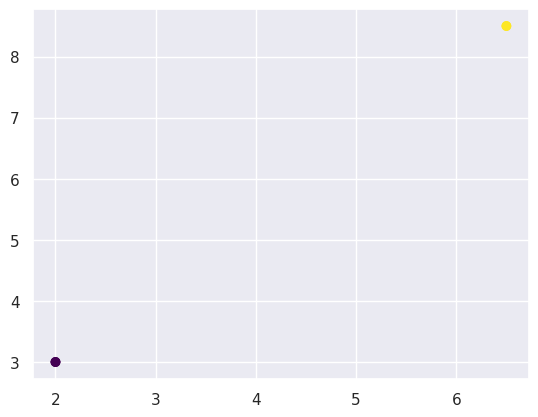

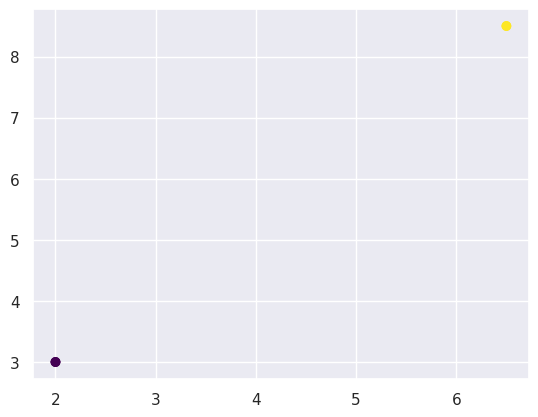

Convergência na iteração 1


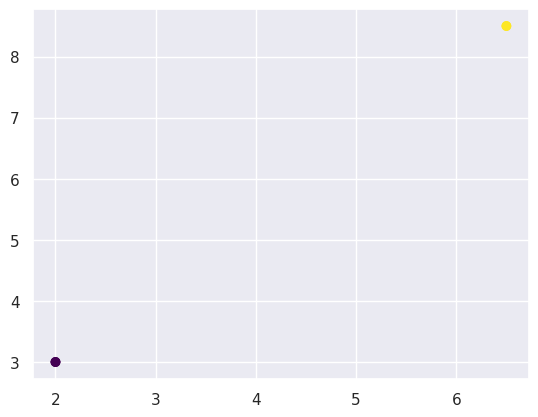

In [25]:
X = np.array([[1, 2], [2, 3], [3, 4], [6, 8], [7, 9]])
meanshift = MeanShift(max_iter=100, bandwidth=3, tol=1e-4)
centroids = meanshift.fit(X, kernel = 'Flat');


In [26]:
print(centroids)


[[2.  3. ]
 [2.  3. ]
 [2.  3. ]
 [6.5 8.5]
 [6.5 8.5]]


Teste com Gaussiano:

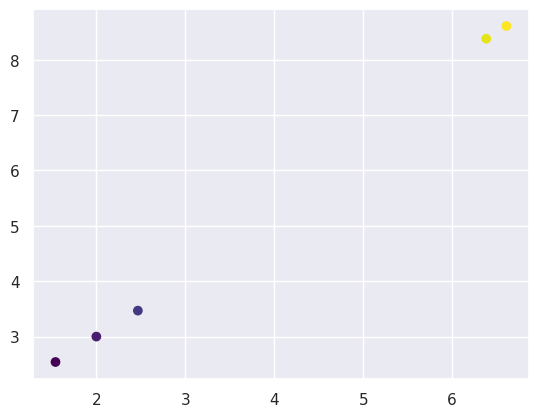

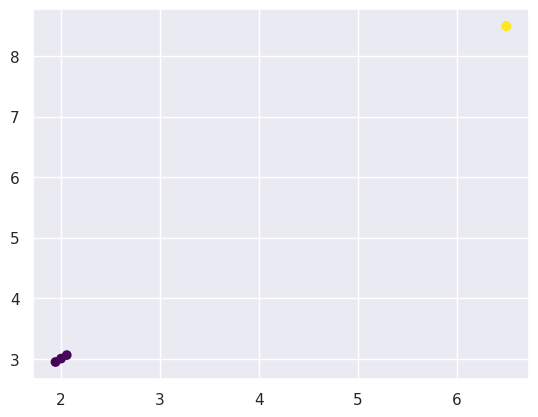

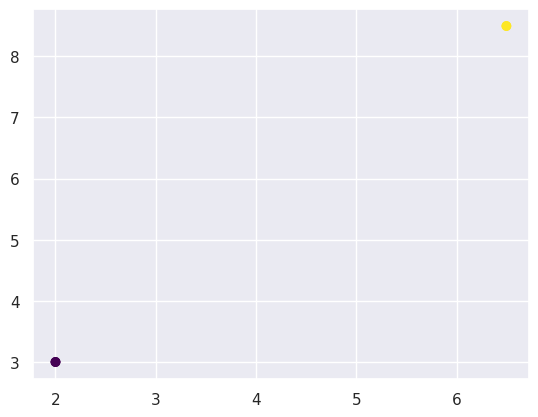

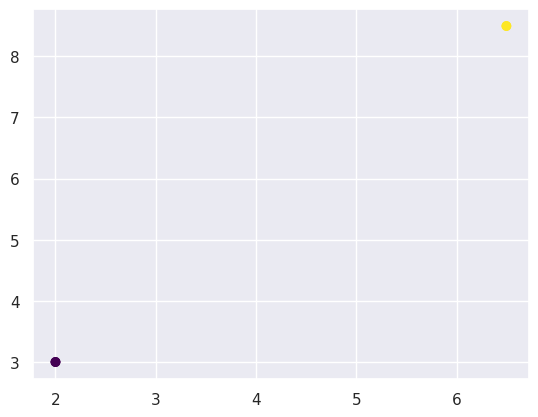

Convergência na iteração 3


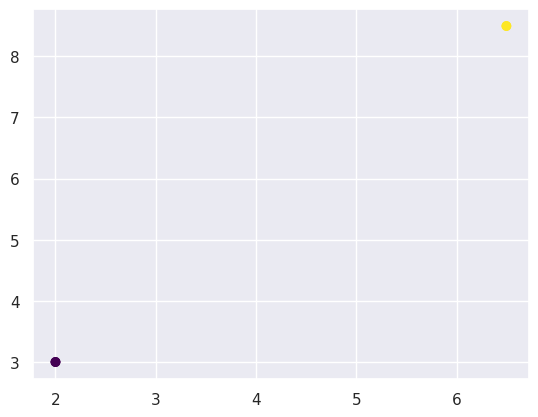

[[2.00267815 3.00345605]
 [2.00267817 3.00345608]
 [2.00267819 3.00345611]
 [6.49529277 8.49394417]
 [6.49529277 8.49394417]]


In [27]:
X = np.array([[1, 2], [2, 3], [3, 4], [6, 8], [7, 9]])
meanshift = MeanShift(max_iter=100, bandwidth=1.5, tol=1e-4)
centroids = meanshift.fit(X, kernel = 'Gaussian')
print(centroids)


Agora teste um modelo maior:

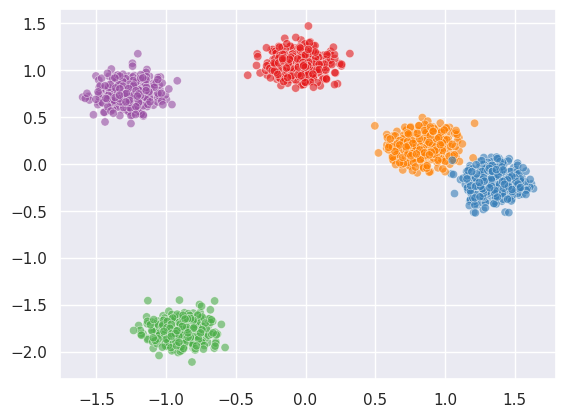

In [28]:
centers = 5
X_train, true_labels_train = make_blobs(n_samples=2000, centers=centers, cluster_std=0.60, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
sns.scatterplot(x=X_train[:,0], #[X[0] for X in X_train],
                y= X_train[:, 1], #[X[1] for X in X_train],
                hue=true_labels_train,
                palette="Set1", alpha = 0.6,
                legend=None
                );


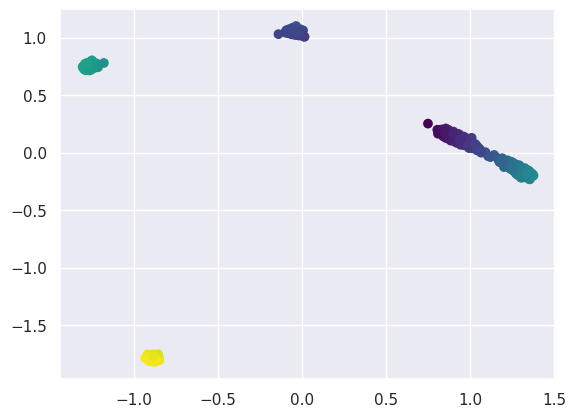

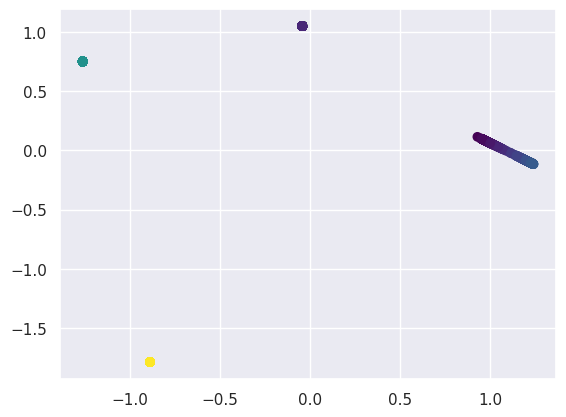

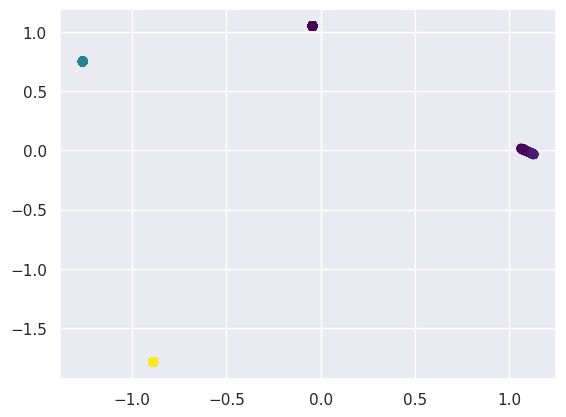

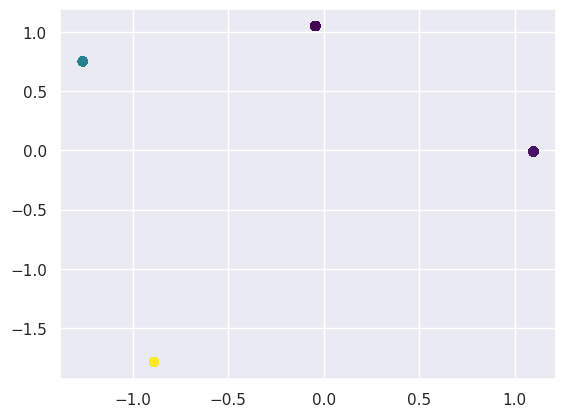

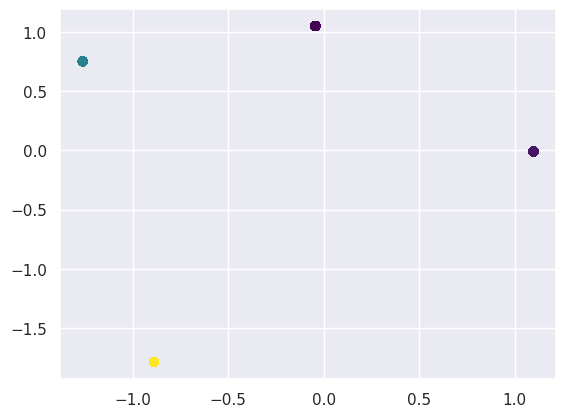

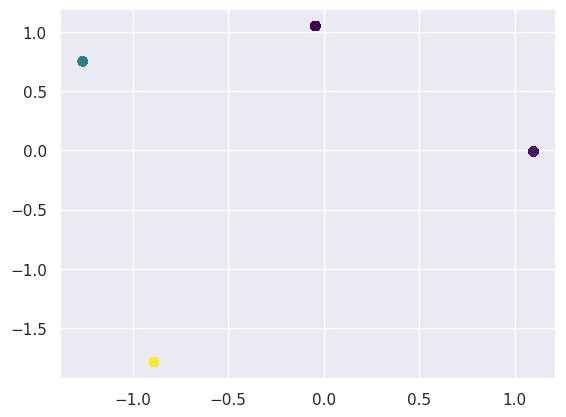

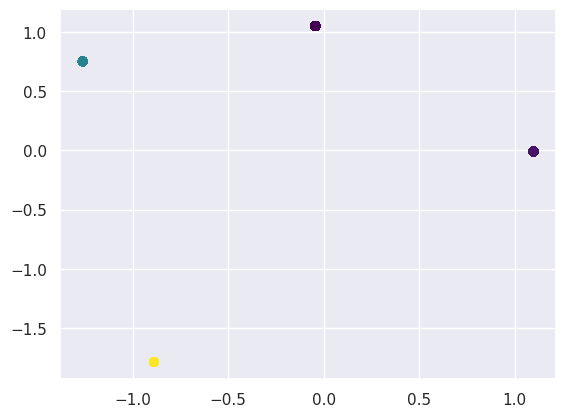

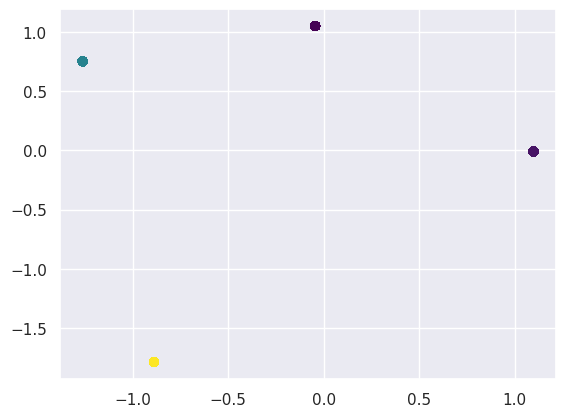

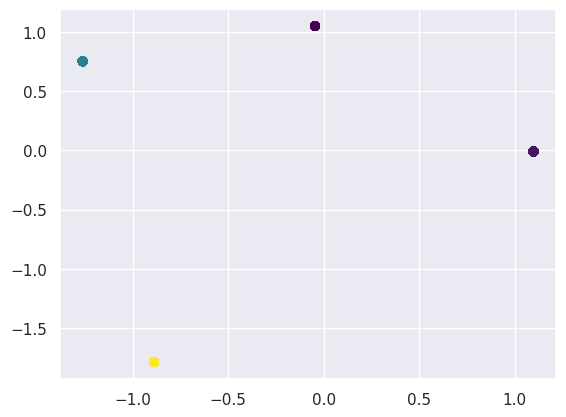

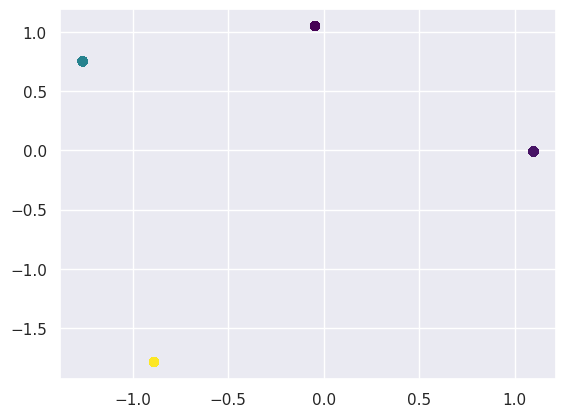

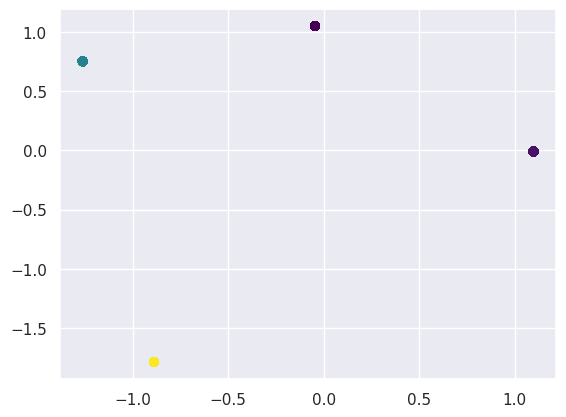

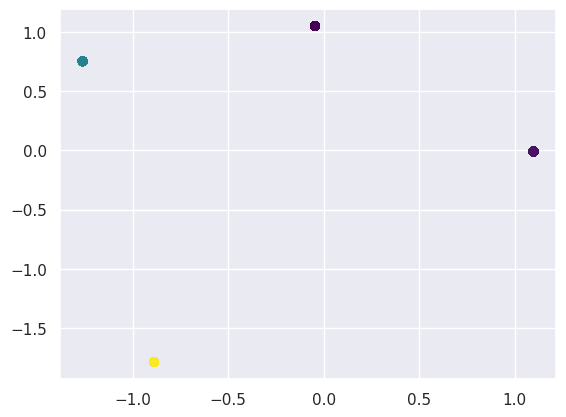

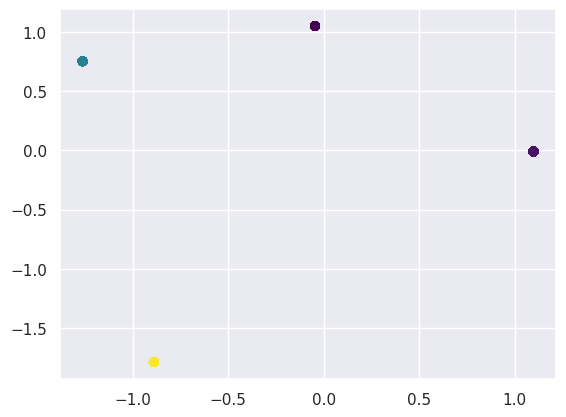

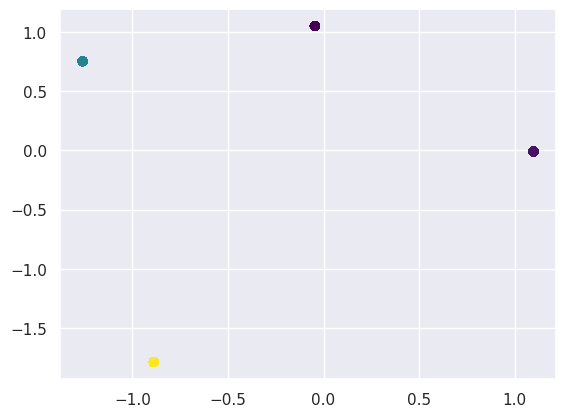

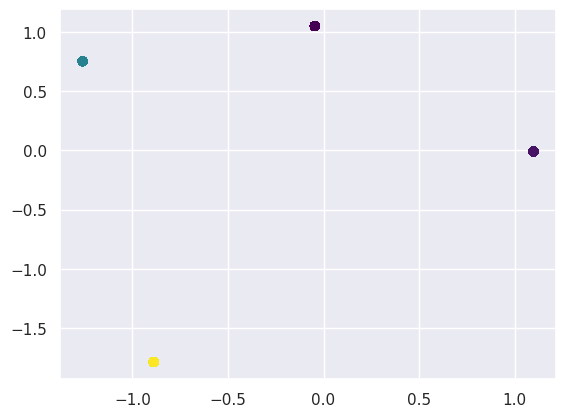

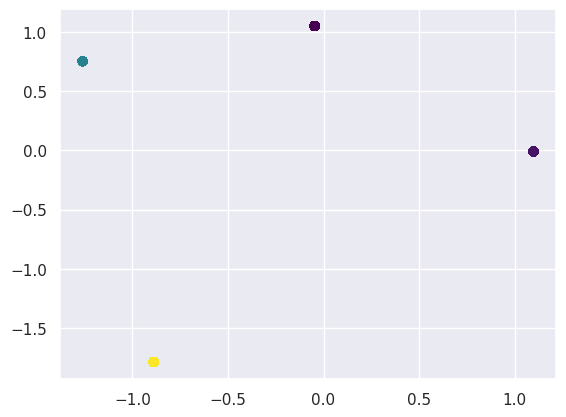

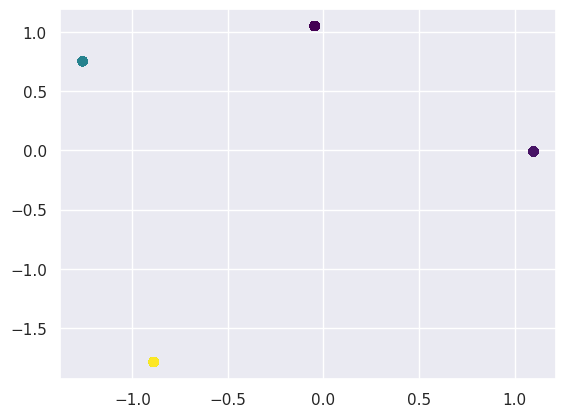

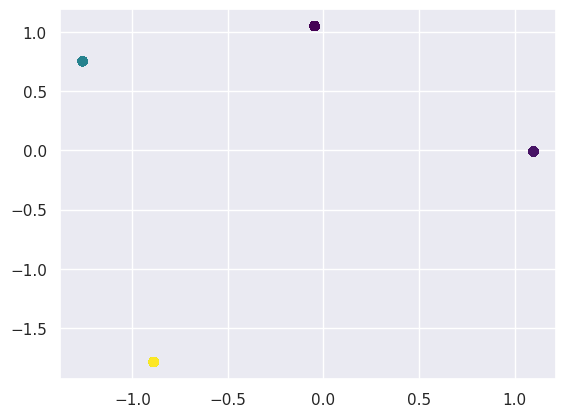

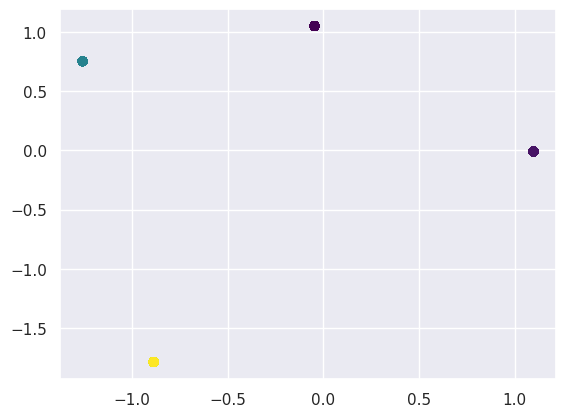

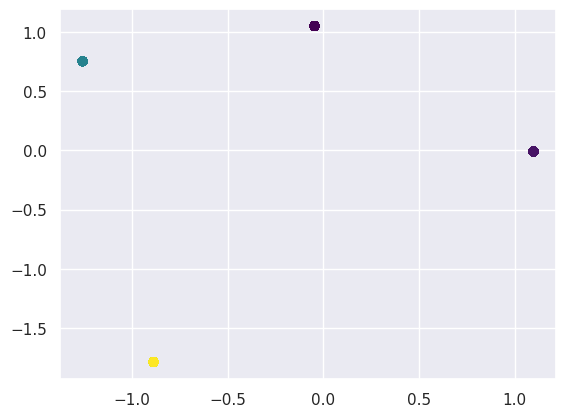

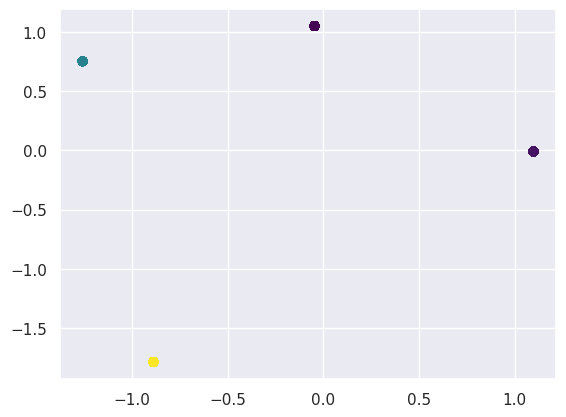

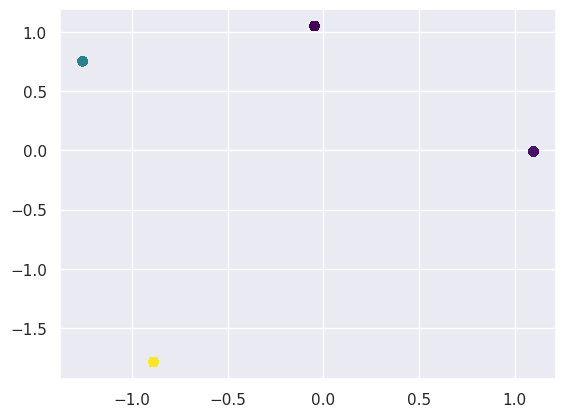

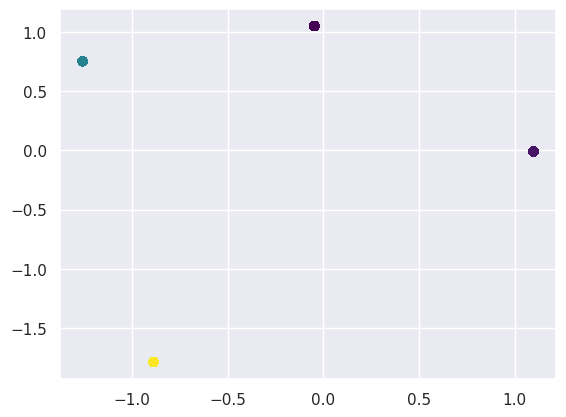

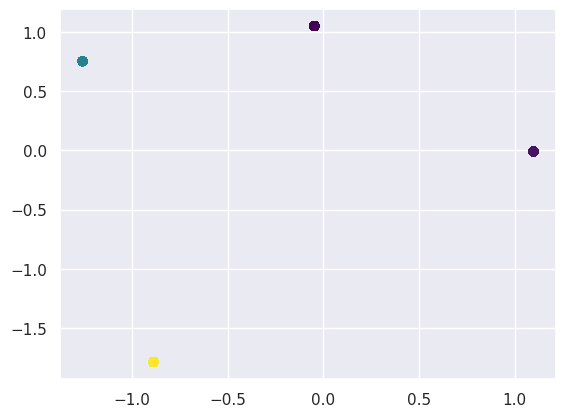

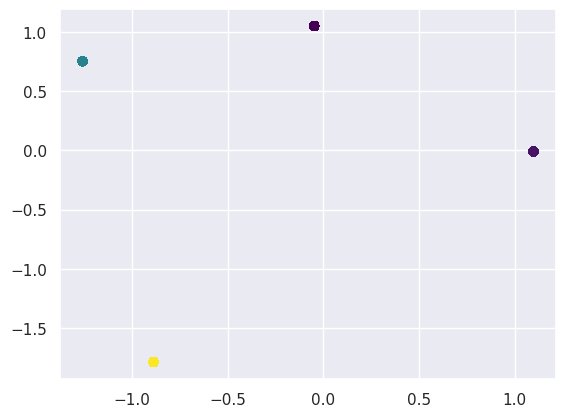

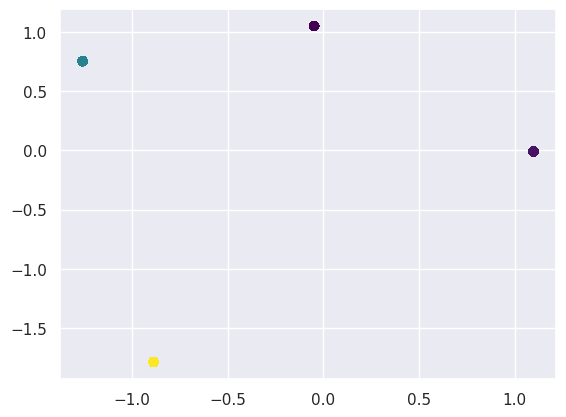

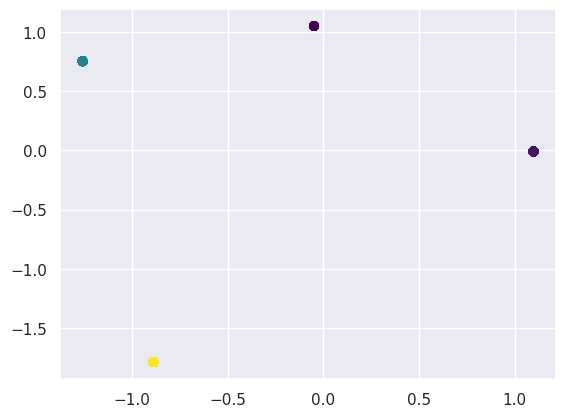

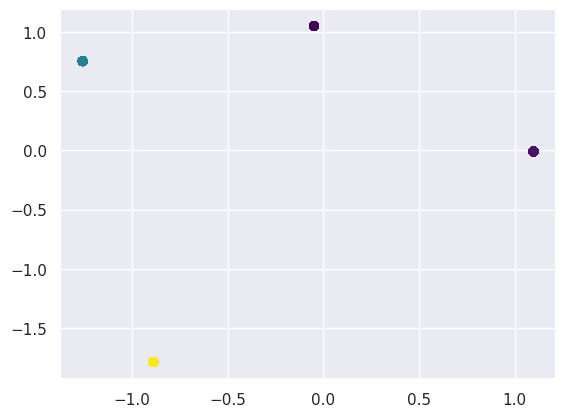

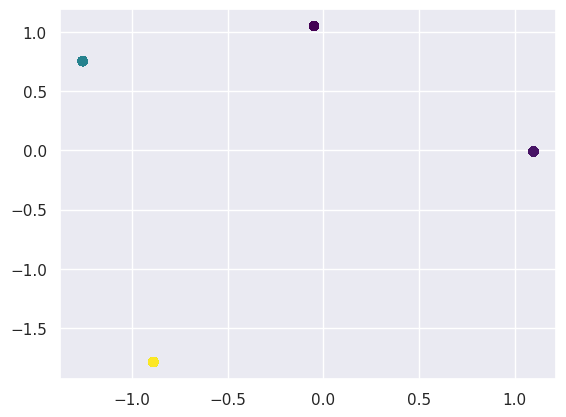

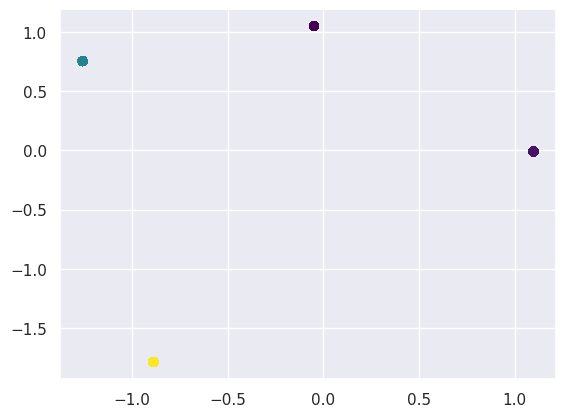

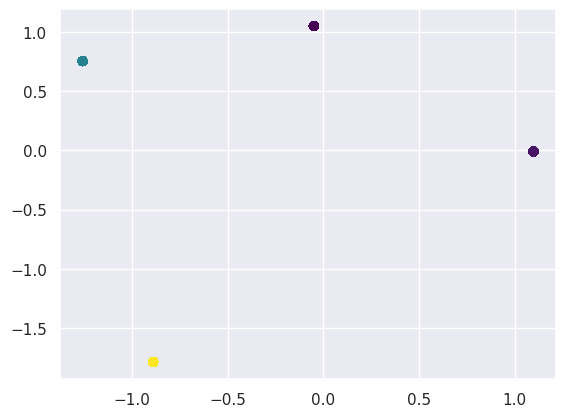

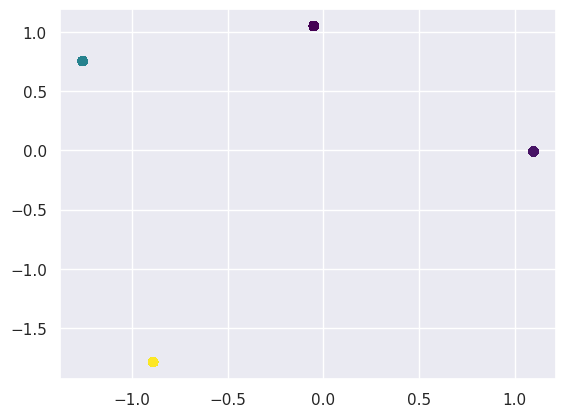

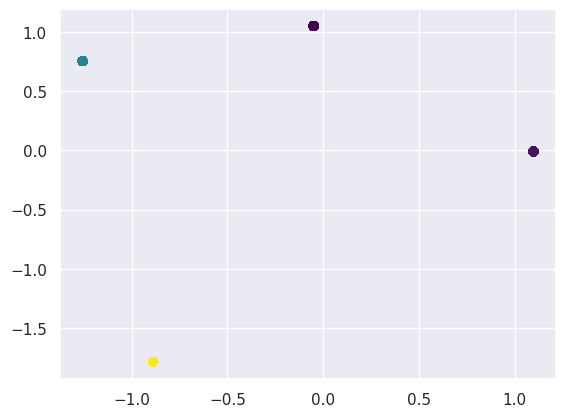

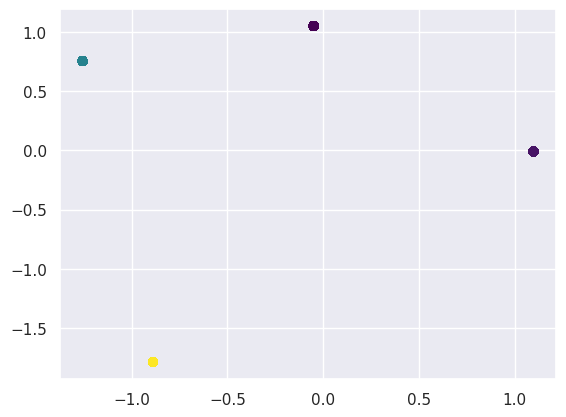

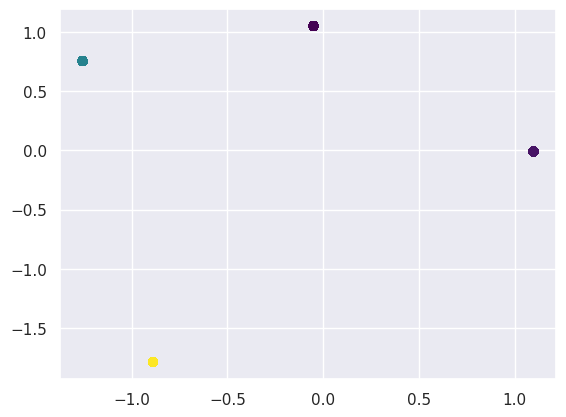

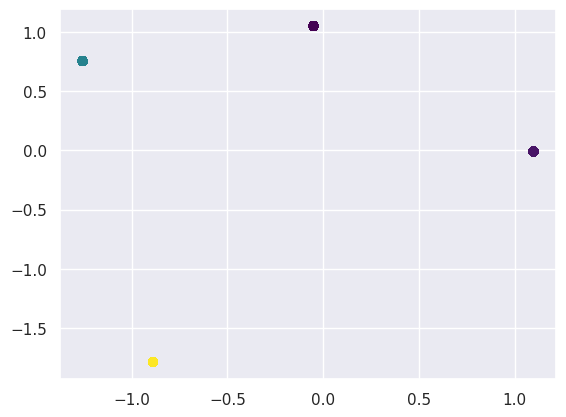

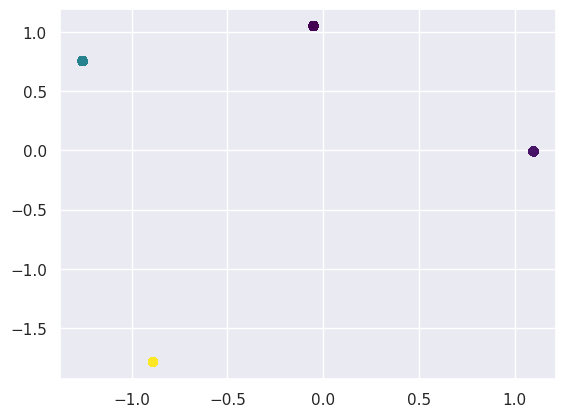

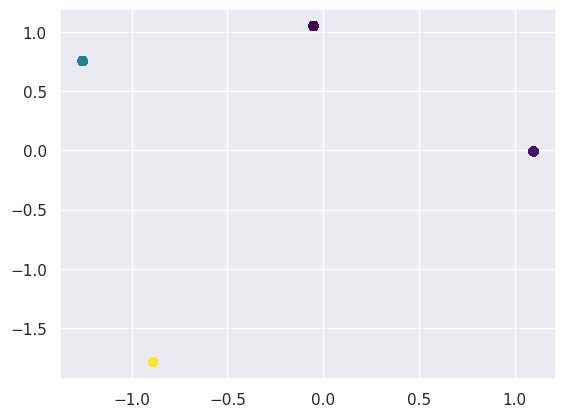

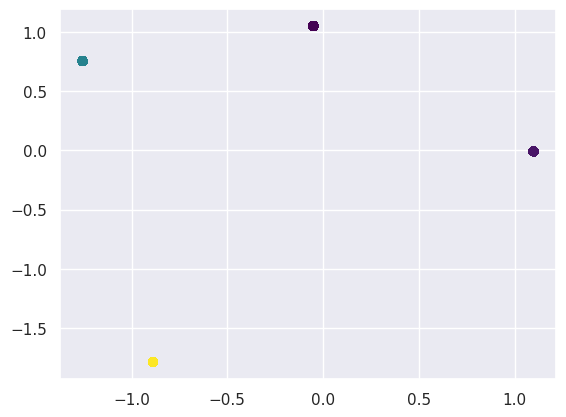

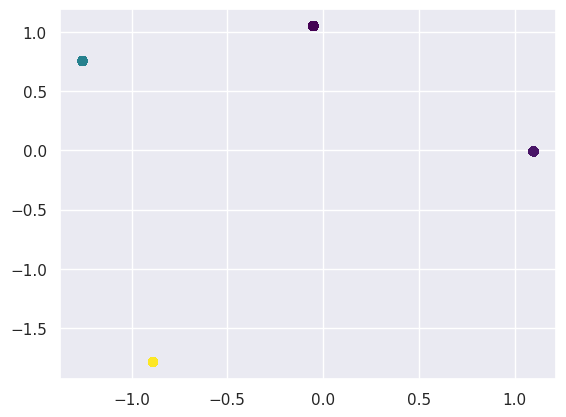

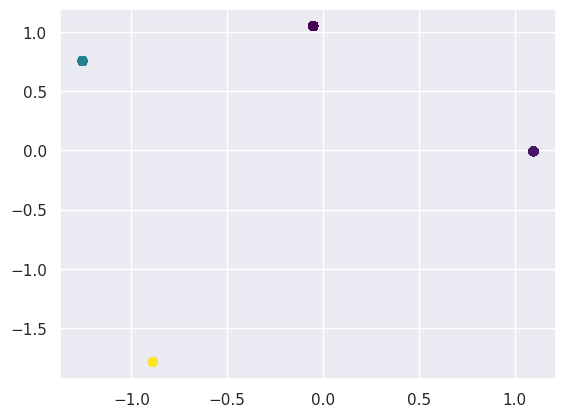

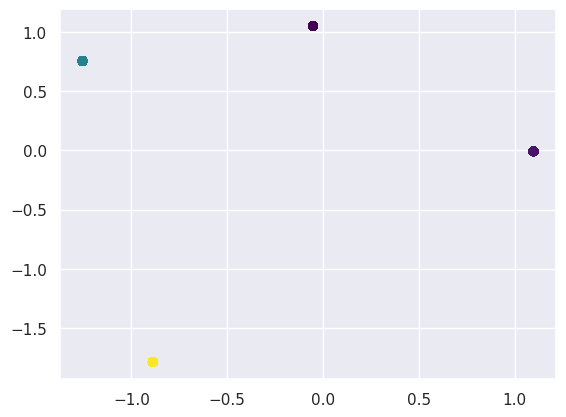

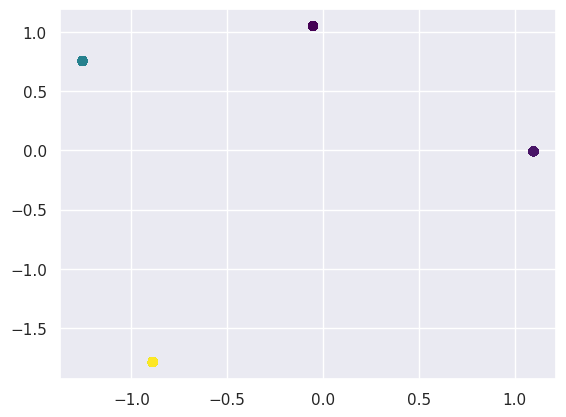

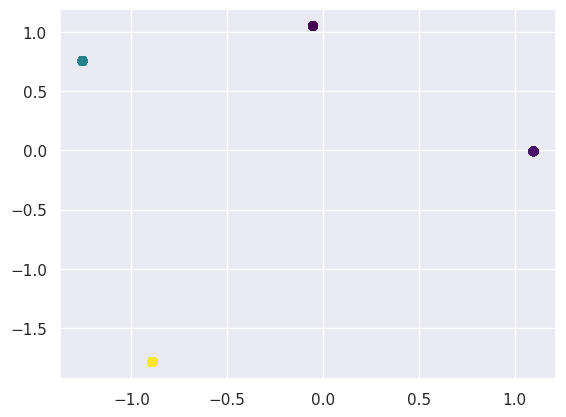

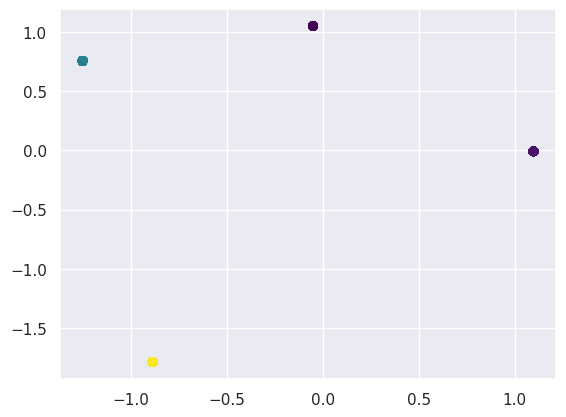

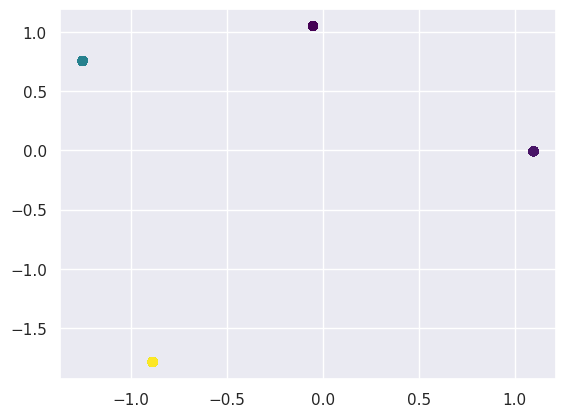

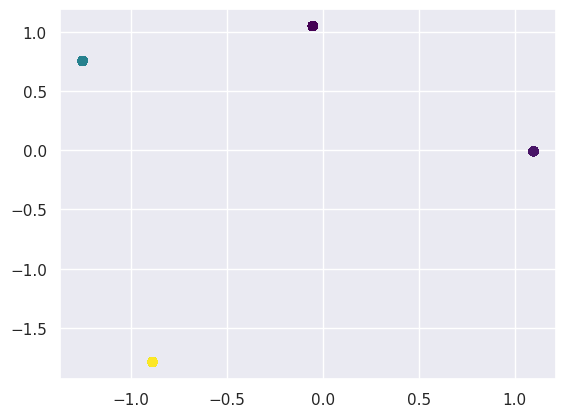

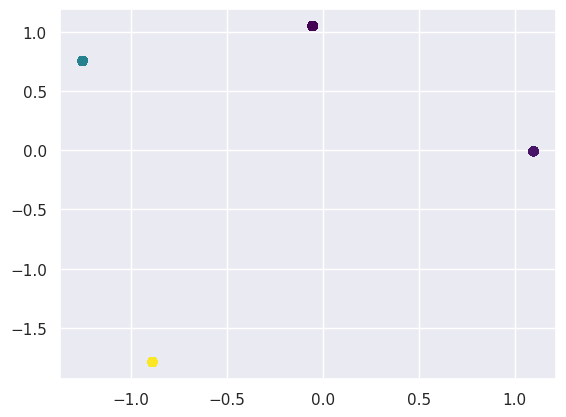

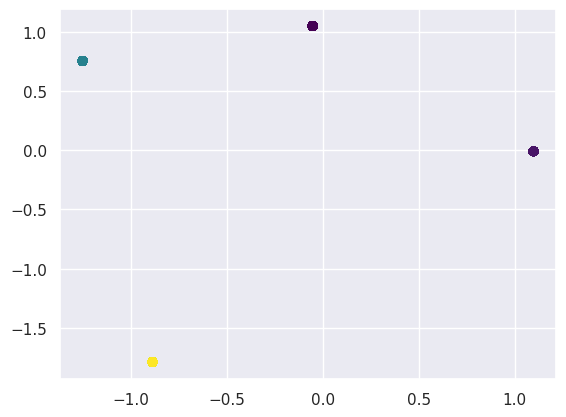

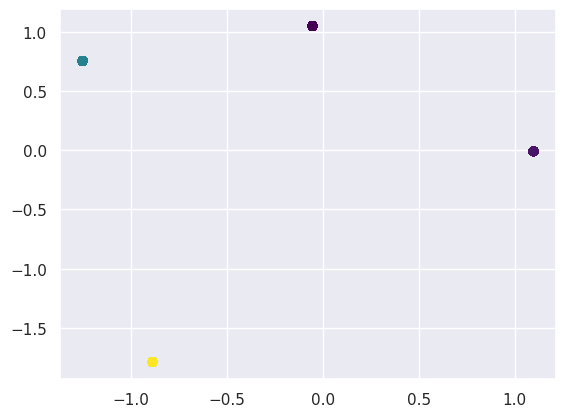

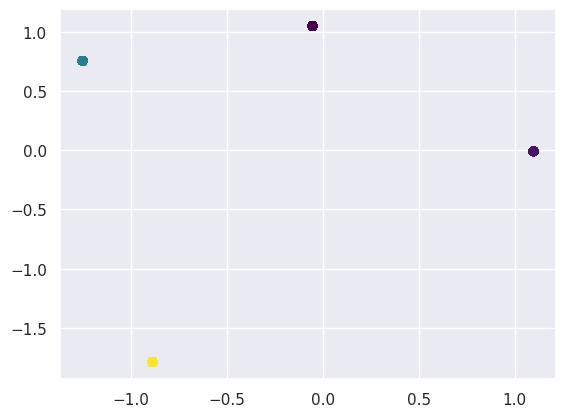

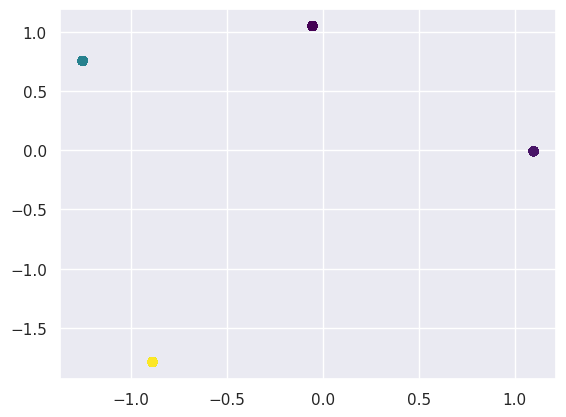

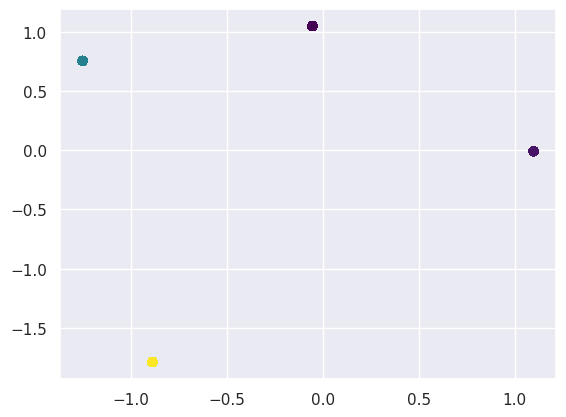

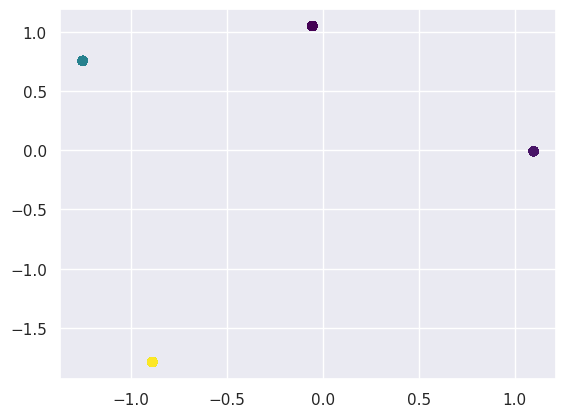

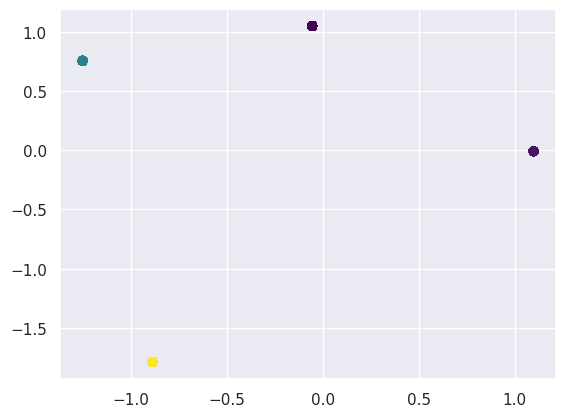

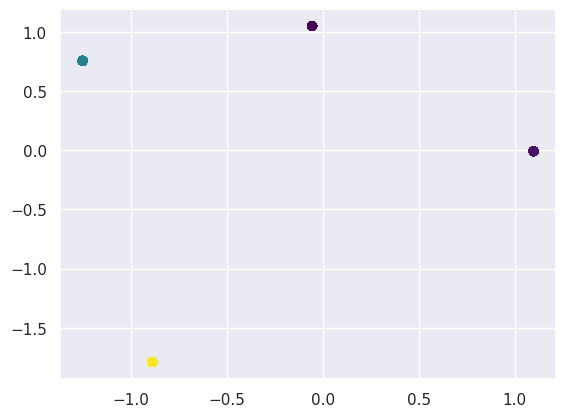

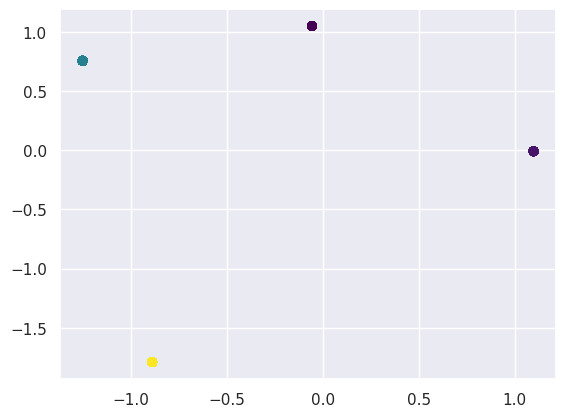

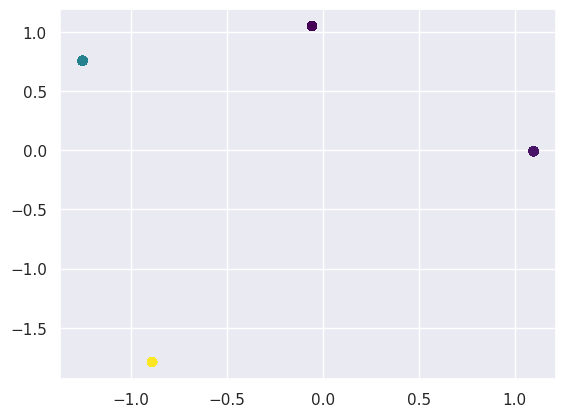

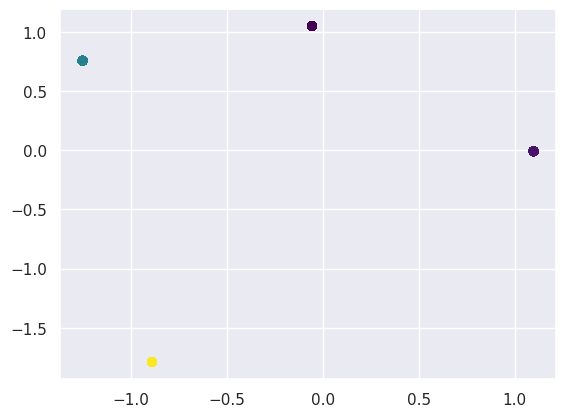

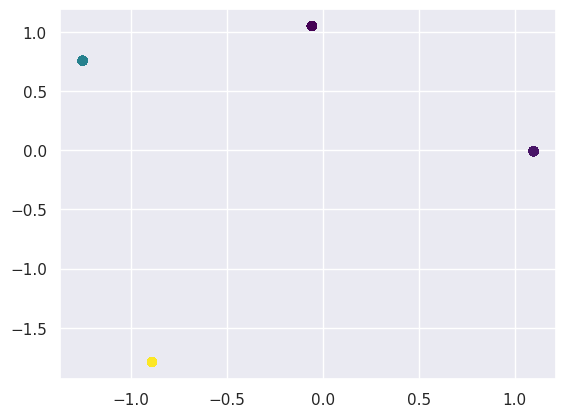

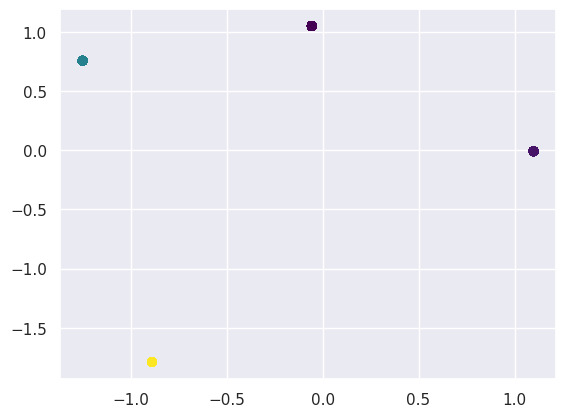

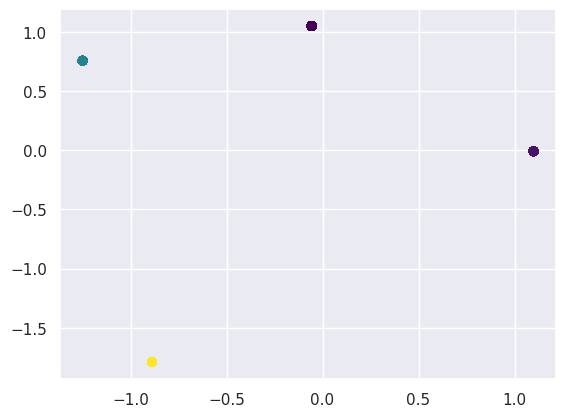

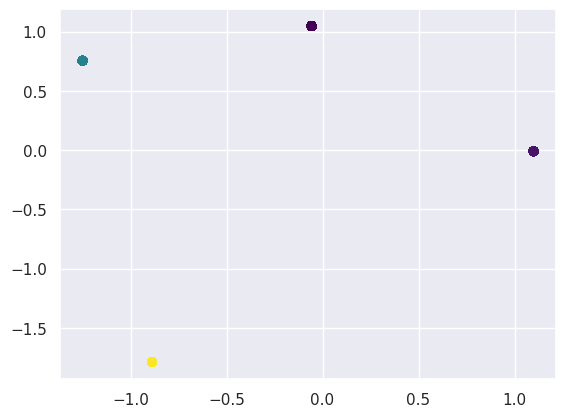

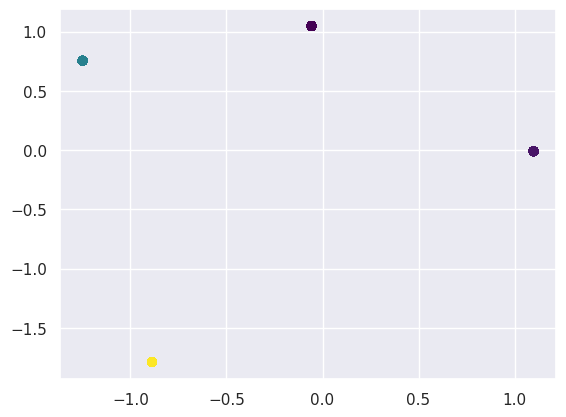

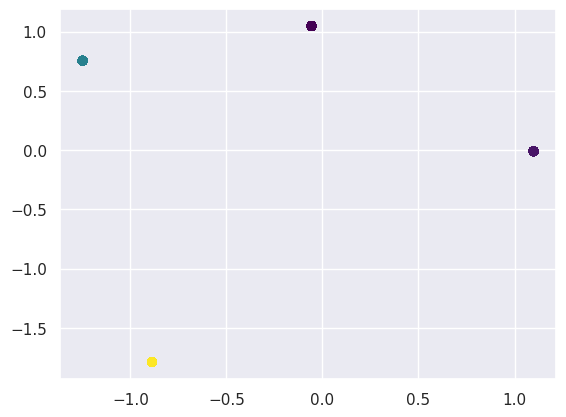

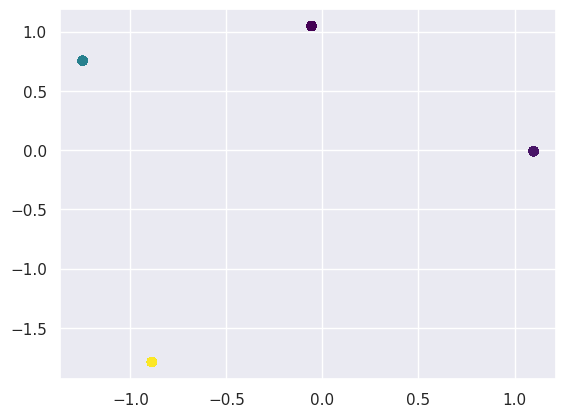

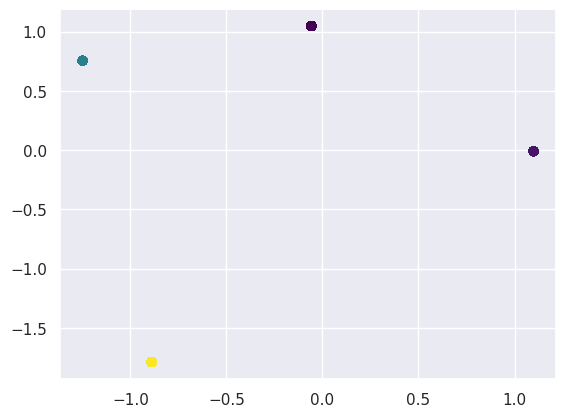

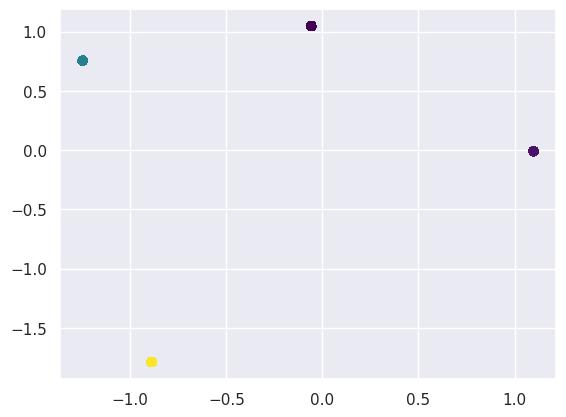

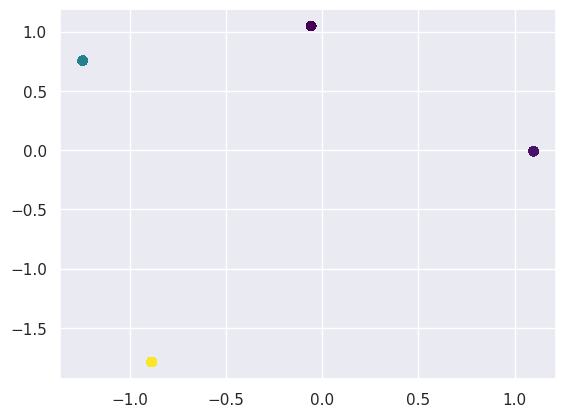

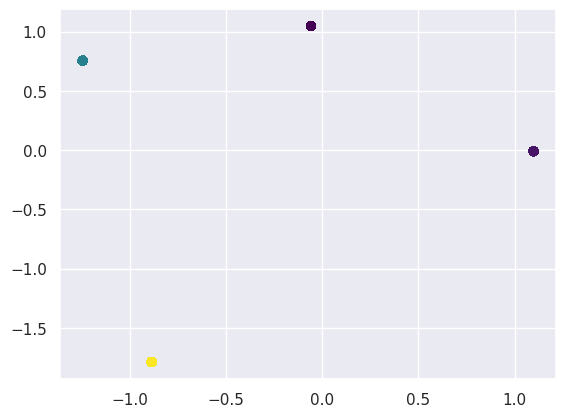

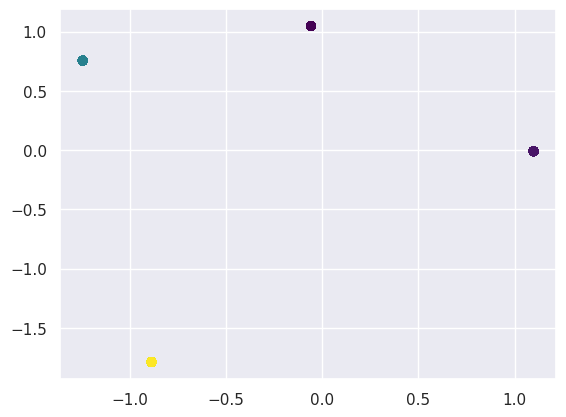

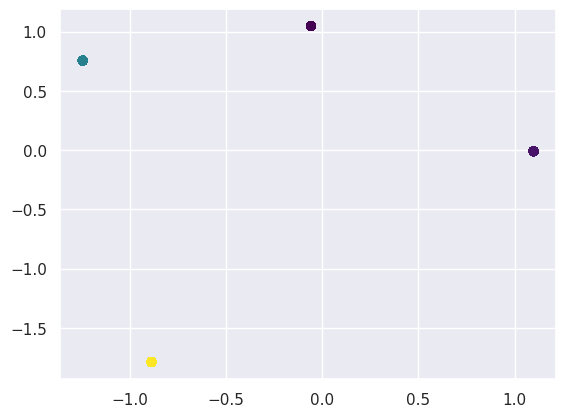

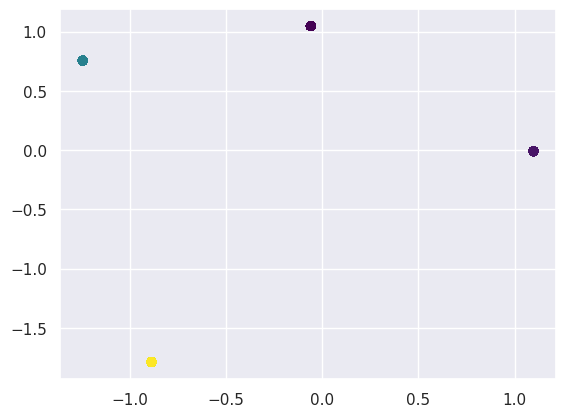

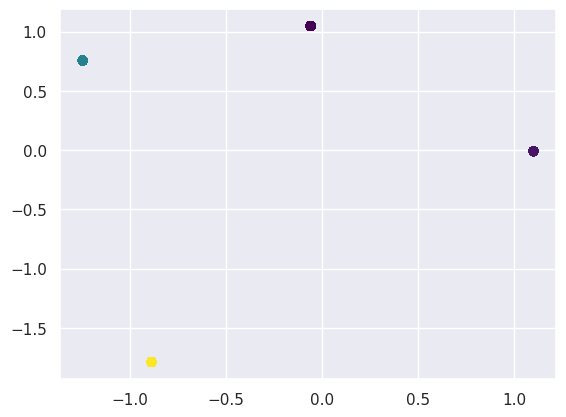

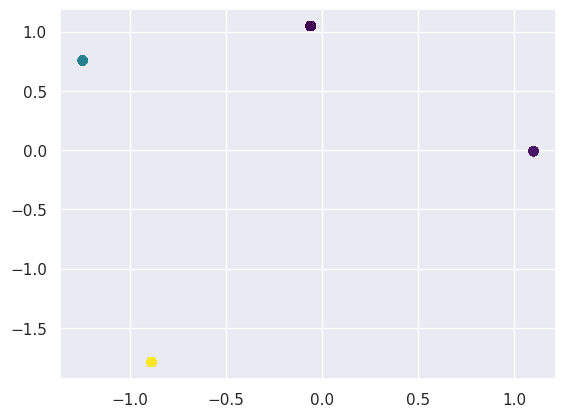

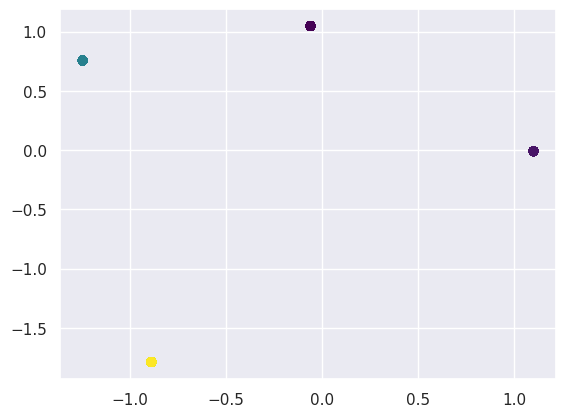

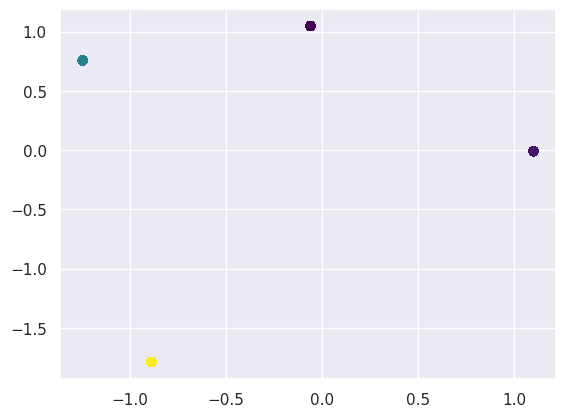

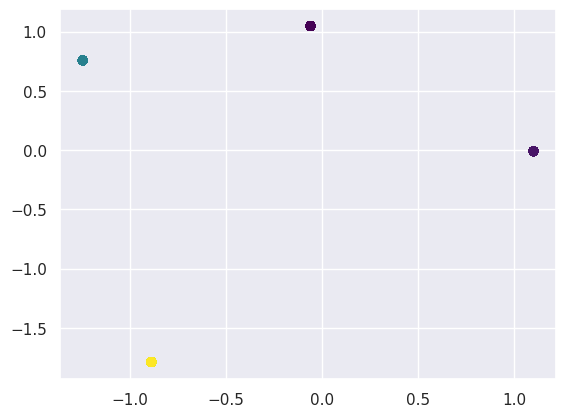

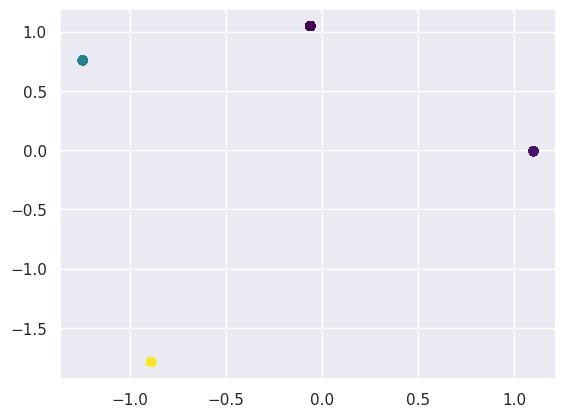

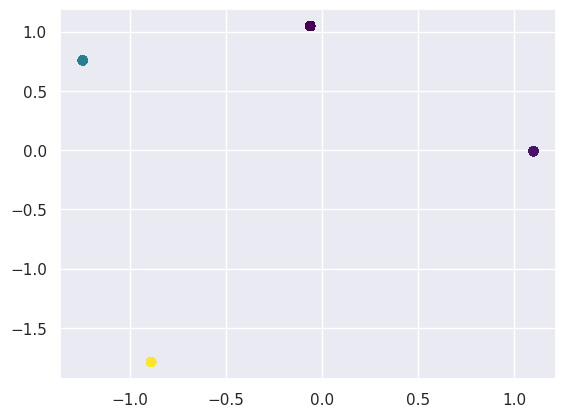

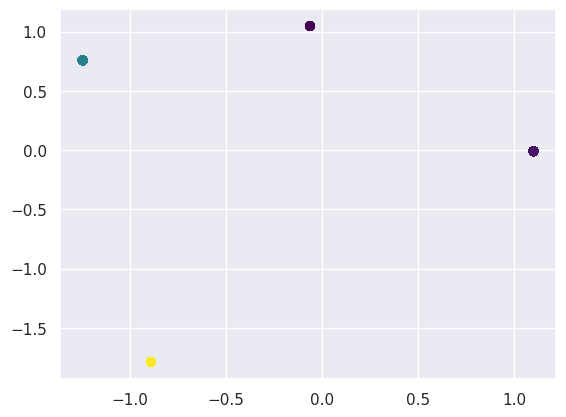

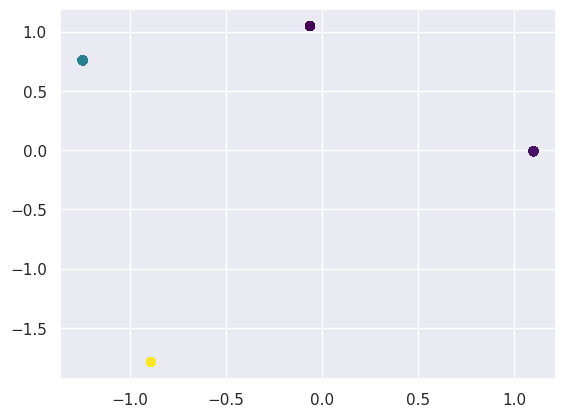

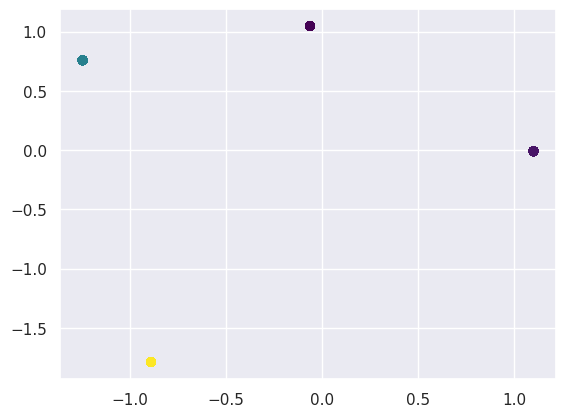

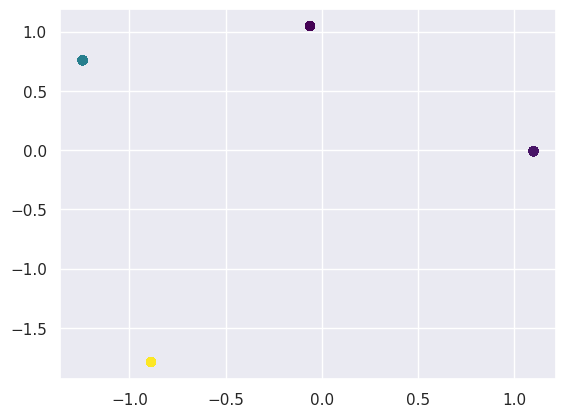

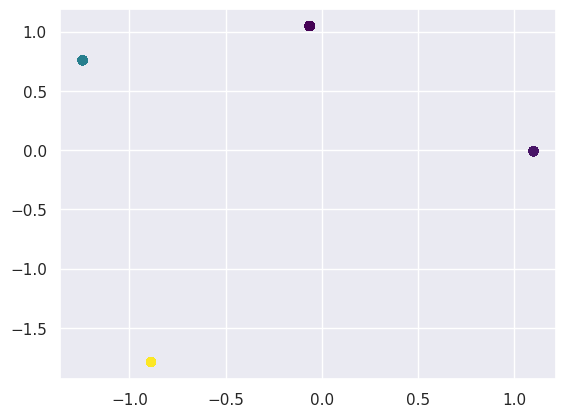

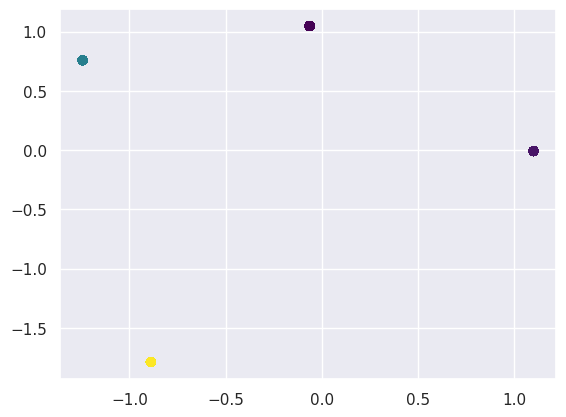

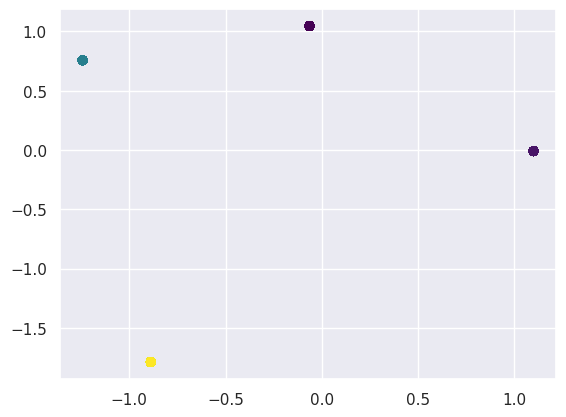

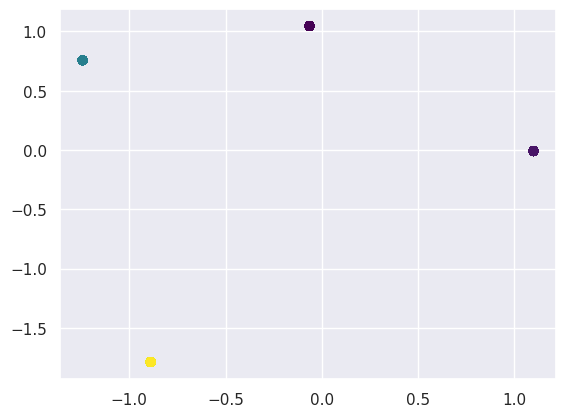

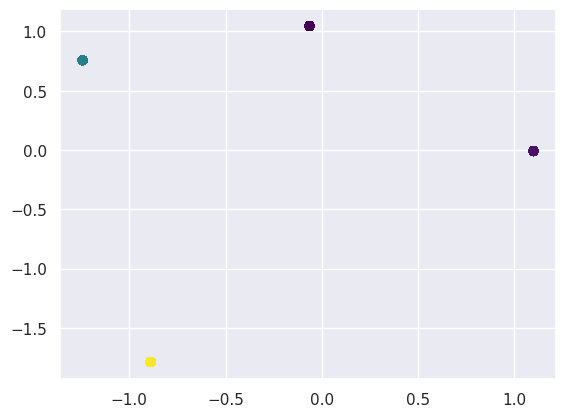

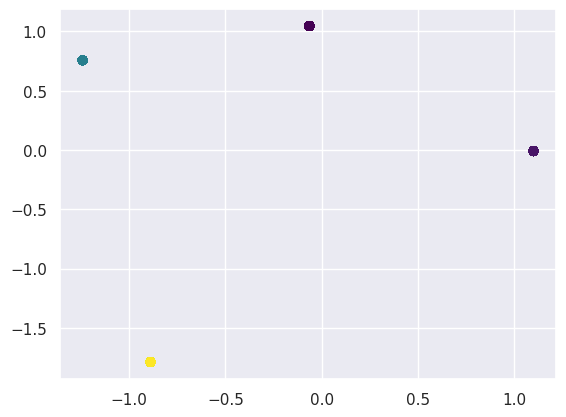

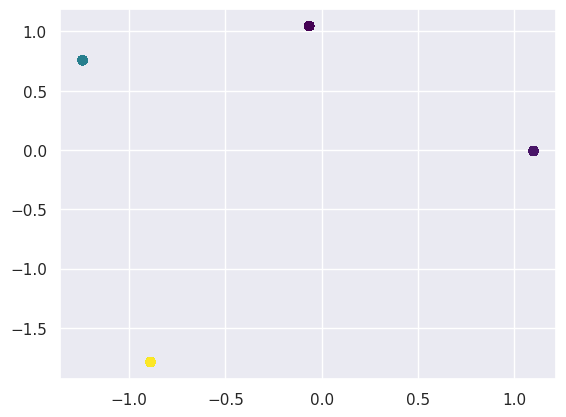

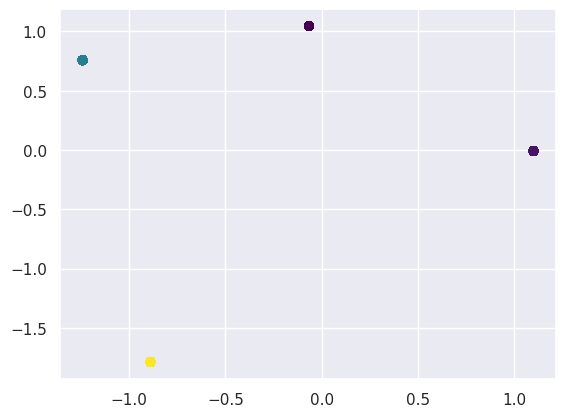

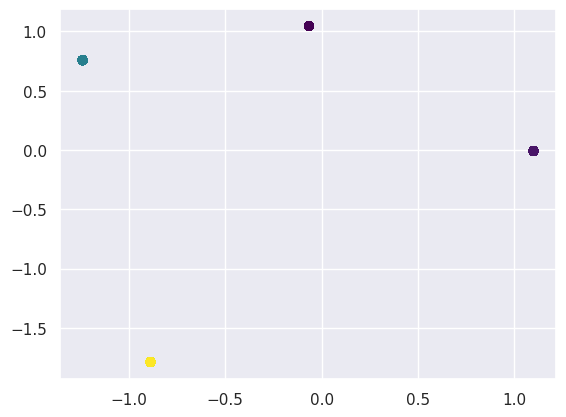

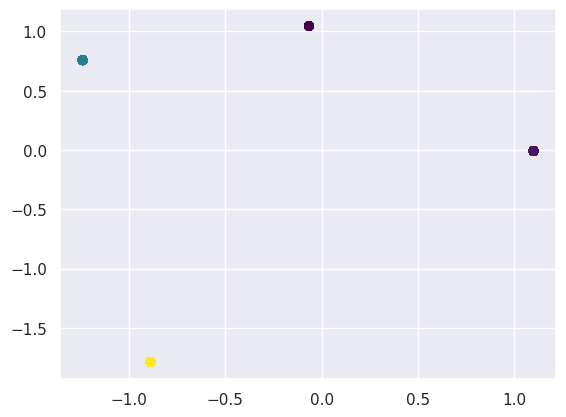

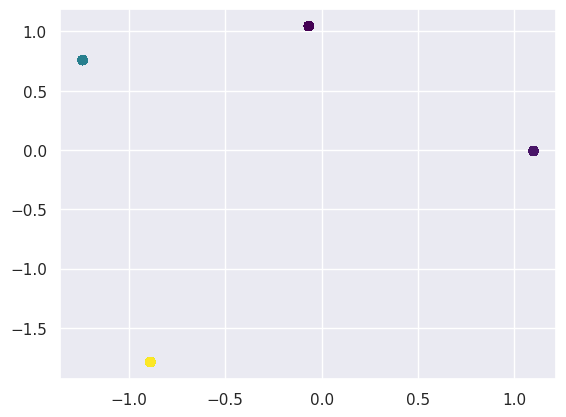

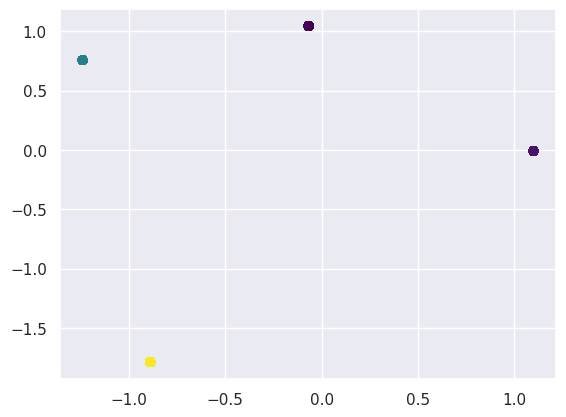

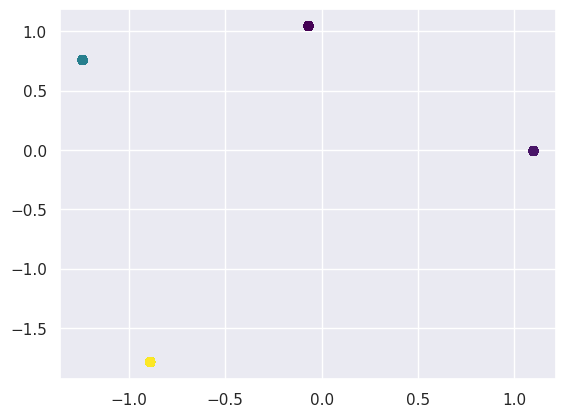

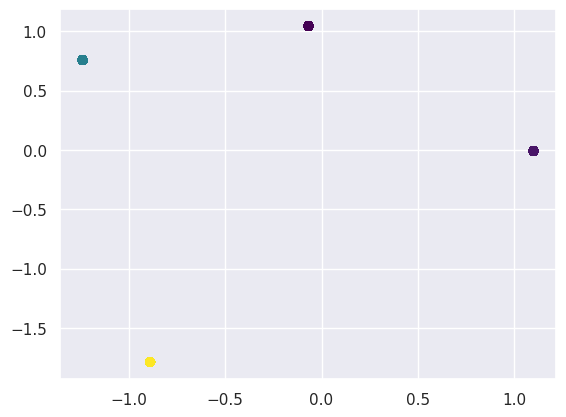

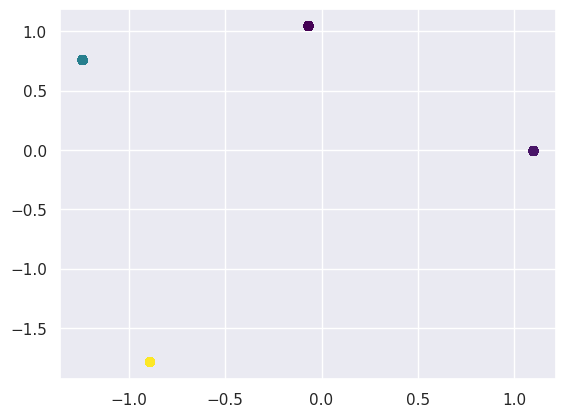

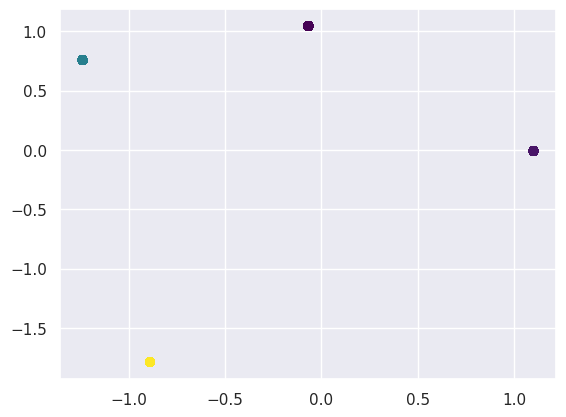

In [29]:
meanshift = MeanShift()
meanshift.fit(X_train);


# PCA

Pense em um livro grande...

<center><img src='https://drive.google.com/uc?export=view&id=1sWQKalXLKWKXpkC7DFowivpvQpCgUehn' width="400"></center>


O PCA é extremamente útil ao trabalhar com conjuntos de dados que possuem muitas características. Embora ter mais dados seja sempre ótimo, às vezes eles têm tantas informações que teríamos um tempo de treinamento de modelo incrivelmente longo e a maldição da dimensionalidade começa a se tornar um problema.

<center><img src='https://drive.google.com/uc?export=view&id=14CMKgvh1VkHwxUyhvONq1TBjXT_FwhgY' width="400"></center>

Intuitivamente, PCA é um método de transformação que converte uma matriz de dados com características possivelmente correlacionadas em um conjunto de variáveis linearmente não correlacionadas, chamadas componentes principais. Cada componente principal é uma combinação linear dos dados originais.



## Ideia por trás do PCA


> *The central idea of principal component analysis (PCA) is to reduce the dimensionality of a data set consisting of a large number of interrelated variables, while retaining as much as possible of the variation present in the data set. This is achieved by transforming to a new set of variables,
the principal components (PCs), which are uncorrelated, and which are ordered so that the first few retain most of the variation present in all of the original variables.* Principal Component Analysis, de  I.T. Jolliffe, Springer Science & Business Media, 5th edition, 2002.

Redução de dimensionalidade significa projetar dados em um espaço de menor dimensão, o que facilita a análise e a visualização de dados. No entanto, a redução da dimensão requer uma troca entre precisão (altas dimensões) e interpretabilidade (baixas dimensões).

Se encontrarmos uma maneira de eliminarmos dimensões redundantes ou com pouca ou nenhuma informação, tornaremos nossos dados mais *legíveis*. Os dados se tornam ilegíveis devido a dois possíveis conflitos: ruído e redundância.

O ruído em qualquer conjunto de dados deve ser baixo ou – não importa a técnica de análise – nenhuma informação sobre um sistema pode ser extraída.

Além disso, é essencial identificar variáveis fortemente dependentes porque elas contêm informações viesadas e redundantes, o que reduz o desempenho geral do modelo.

Portanto, a ideia principal da análise de componentes principais (PCA) é encontrar padrões e correlações entre diferentes características do conjunto de dados de modo que este possa ser transformado em um conjunto de dados de dimensão significantemente menor sem perda de informação importante!

## O poder da variância

O PCA pode entender qual parte de nossos dados é importante? Podemos quantificar matematicamente a quantidade de informação incorporada nos dados?

Bem, a variação pode.
__Quanto maior a variação, mais informações. Vice-versa.__

## Breve Recap

Para uma determinada variável, a quantidade de informação nela é proporcional à sua variância. Simples de perceber, pois se todos os dados são constantes, sua variância é zero e a informação que aquele dado nos fornece também é nula. Defina, por exemplo, na ilustração abaixo, com imagens embaçadas de seus amigos, em qual dos dois casos a tabela fornece informações importantes. Você deve concordar que é aquela em que há maior variância na altura dos amigos...

<center><img src='https://drive.google.com/uc?export=view&id=1OlPeYgiWQQZeRvUyvv7MEzBL0WIeoWKu' width="600"></center>

Se tivermos dados de muitas dimensões, podemos reduzir sua dimensionalidade projetando-os ao longo de direções específicas, de modo que a variância na direção escolhida seja maximizada, para preservar o máximo de informações contidas nos dados.

É exatamente o papel do PCA. A análise de componentes principais é um método para encontrar direções ortogonais de variância máxima nos dados e projetar os dados nessas direções.

Qual é essa direção de máxima variação? Para isso devemos recordar as definições de variância e covariância.

Basicamente, variância mede a variação de uma única variável aleatória (como a altura de uma pessoa em uma população), enquanto covariância é uma medida de quanto duas variáveis aleatórias variam juntas (como a altura e peso de uma pessoa em uma população).


A variância e a covariância são afetadas pela *disseminação* dos dados em torno da média. Mas o que a variação e a covariância significam?

Além disso, qual a diferença entre covariância e correlação?

### Variância


A variância é simplesmente uma medida da dispersão em torno da média - se as amostras de dados forem muito diferentes umas da outra, a variância será alta e vice-versa. Dado um conjunto de dados $\mathbf x$, estes apresentam um valor *médio* $\bar x$ e uma *variação* sobre essa média $s_x^2$. Tecnicamente **a variância é a média do quadrado diferenças dos dados com relação à média**,

$$s_x^2 =  {\rm Var} (\mathbf x) = {1 \over m-1} \sum_ {j = 1}^m (x_j- \bar x)^2, $$

Pense na variância como a "propagação" ou "extensão" dos dados, sobre algum eixo específico.

A ressalva é que estamos dividindo por $ m-1 $ em vez de $ m $, então, não estamos calculando exatamente uma média. Para grandes conjuntos de dados, isso não faz diferença, mas para um pequeno número de pontos de dados, $m-1$ é introduzido como forma de reduzir o viés de amostra.

Importante ressaltar que a variância calculada em python com o comando `np.var`, por default, refere-se à população, com a opção `ddof=0`, e, portanto, a fórmula acima de $s_x^2$ é divida por $m$ e não por $m-1$. Para calcular a variância de uma amostra, deve-se usar a opção `ddof=1`.


#### Exemplo

Os dados abaixo referem-se ao peso e altura de 4 pessoas. Monte a matriz $\mathbf X$ e calcule a matriz de covariância usando as fórmulas que aprendemos.

\begin{array}{c} \hline
Pessoa & Altura [cm] & Peso [kg] \\ \hline
1 & 149 & 48 \\
2 & 155 & 52 \\
3 & 163 & 57 \\
4 & 177 & 68 \\ \hline
\end{array}



Veka que, no exemplo, o número de características é $n=2$ (altura, peso) e o número de observações é $m=4$. Portanto, a matriz $\mathbf X$ terá dimensão $m \times n$, isto é, $4 \times 2$.

In [30]:
X = np.array([[149,48],[155,52],[163,57],[177,68]])
print(X)
print(X.shape)

print("Média Altura =",np.mean(X,axis=0)[0])
print("Média Peso =",np.mean(X,axis=0)[1])

print("Variância Altura =",np.var(X, axis = 0, ddof=1)[0])
print("Variância Peso =",np.var(X, axis = 0, ddof=1)[1])


[[149  48]
 [155  52]
 [163  57]
 [177  68]]
(4, 2)
Média Altura = 161.0
Média Peso = 56.25
Variância Altura = 146.66666666666666
Variância Peso = 74.91666666666667


### Covariância e correlação

No exemplo anterior, quando $x_1$ (altura) varia, $x_2$ (peso) praticamente varia junto. Então $x_2$ é *covariante* com $x_1$. A covariância indica o nível em que duas variáveis ​​variam juntas,
$$
{\rm Cov} (\mathbf{x}_1,\mathbf{x}_2) = s_{12}= {1 \over m-1} \sum_{j = 1}^m (x_{j1} - \bar {x}_1) (x_{j2} - \bar {x}_2),
$$
onde $\bar {x}_1$ e $\bar {x}_2$ são as médias das componentes $\mathbf{x}_1$ e $\mathbf{x}_2$ dos dados, respectivamente. Ressalta-se novamente que dividimos por $m-1 $ em vez de $m$, para reduzir o  viés de pequenas amostras.

Uma covariância positiva, como no exemplo acima, diz que as duas variáveis *andam juntas*, isto é, em média, quando $\mathbf{x}_1$ cresce $\mathbf{x}_2$ também cresce, e vice-versa. Se a covariância for negativa, então, quando uma variável está crescendo, a outra variável, para a mesma amostra, está diminuindo.

Ainda, se dividirmos covariância pelos dois desvios padrão, obteremos uma medida sem dimensão denominada coeficiente de correlação:
$$
r_{12} = \frac{{\rm Cov} (\mathbf{x}_1,\mathbf{x}_2)}{{s_1} s_{2}},
$$
onde $s_1$ e $s_2$ são o desvio padrão (raíz quadrada da variância) da variável $\mathbf{x}_1$ e da variável  $\mathbf{x}_2$, respectivamente.

O coeficiente de correlação $r_{12}$ é usado para medir *a força* dessa correlação e pode assumir valores entre $+1$ e $-1$. Valor $r=+1$ indica uma correlação positiva perfeita entre variáveis. Uma correlação negativa perfeita leva ao valor de $r=-1$. Valor $r=0$ é quando ambas as variáveis são completamente independentes uma da outra.


Generalizando, dada uma matriz dos dados de entrada $\mathbf X_{m,n}$, onde cada linha é um conjunto de observações das variáveis,
\begin{equation}
 \mathbf x_i =
\begin{pmatrix}
x_{i1} & x_{i2} & \cdots & x_{in}
\end{pmatrix}, \quad i=1,\cdots,m
\end{equation}
e cada coluna representa várias medições da mesma variável.
\begin{equation}
  \hat{\mathbf x}_i =
\begin{pmatrix}
x_{1i} \\
 x_{2i}\\
  \cdots \\
   x_{mi}
\end{pmatrix}, \quad i=1,\cdots,n
\end{equation}


Dessa forma, as componentes $s_{jk}$ $(j,k = 1,\cdots,n)$ da matriz de covariância $\mathbf S$ podem ser definidas como,

$$
s_{jk} = {\rm Cov} (\mathbf x_j,\mathbf x_k) = {1 \over m-1} \sum_{i = 1}^m (x_{ij} - \bar{x}_j) (x_{ik} - \bar{x}_k), \tag{1}
$$

Verifique que as entradas diagonais da matriz de covariância $\mathbf S$ são as variâncias e as entradas fora da diagonal são as covariâncias. Como a ordem das variáveis não importa ao calcular a covariância, a matriz será *simétrica* e, portanto, *quadrada*.

Outra notação bastante útil é,

$$
\mathbf S = \frac{1}{m-1} \sum^{m}_{i=1}{\left( {\mathbf x}_i - \mathbf{\bar{x}} \right)^T\left({\mathbf x}_i-\mathbf{\bar{x}}\right)}, \tag{2}
$$

onde $\bar{\mathbf x}^T = \left[ \bar{x}_1 \quad \bar{x}_2 \quad  \cdots \quad \bar{x}_n\right]$, de modo que $\bar{x}_j = {1 \over m}\sum_{i=1}^m x_{ij}$ é a média da variável $j$.

Pode-se reescrever a matriz de covariância como,

\begin{equation}
\mathbf S
= {1 \over {m-1}} \left[\mathbf X_c^T \mathbf X_c\right], \tag{3}
\end{equation}
para $X_c = \mathbf X - \mathbf 1_m  \bar{\mathbf x}^T$, onde $\mathbf 1_m^T = \begin{bmatrix}1 & 1 & \cdots& 1\end{bmatrix}$ tem dimensão $m \times 1$.

`Numpy` facilita muito o cálculo da covariância. Porém, ressalta-se que, a princípio, calculamos covariância em amostras, e não na população completa. Portanto, o default do cálculo da matriz de covariância é `np.cov(X.T, bias = False)`. Para obter a covariância da população (com base em $m$), você precisará definir o viés como `bias=True` no código.

Ainda, `Numpy` quer variáveis (características) ao longo de linhas, em vez de colunas... Portanto, a matriz entra como transposta para cálculo da variância. Outra alternativa é usar o parâmetro `rowvar`. Se  `rowvar` for `True` (padrão), cada linha representa uma variável, com observações nas colunas. Caso contrário, a relação é transposta: cada coluna representa uma variável, enquanto as linhas contêm observações.

#### Continuação do Exemplo

Calcule, para o exemplo anterior, calcule a matriz de covariância e de correlação.



In [31]:
#Reescrevendo o vetor X e recalculando as médias:
X = np.array([[149,48],[155,52],[163,57],[177,68]])
xbar = np.mean(X, axis = 0) #média das colunas de X
m,n = X.shape

#Gabarito:
print('Matriz de covariância via Numpy:\n')
cov_x = np.cov(X.T)
print(pd.DataFrame([[cov_x[0][0], cov_x[0][1]],[cov_x[1][0], cov_x[1][1]]], index =("x1", "x2"), columns=['x1', 'x2']))
#print(np.cov(X,rowvar = False),'\n') # alternativa


Matriz de covariância via Numpy:

            x1          x2
x1  146.666667  104.666667
x2  104.666667   74.916667


A matriz de correlação é calculada através do comando,
```
cor = np.corrcoef(X.T)
```



In [32]:
print('Matriz de correlação via Numpy:\n')
cor = np.corrcoef(X.T)
print(pd.DataFrame([[cor[0][0], cor[0][1]],[cor[1][0], cor[1][1]]], index =("x1", "x2"), columns=['x1', 'x2']))


Matriz de correlação via Numpy:

          x1        x2
x1  1.000000  0.998512
x2  0.998512  1.000000


Agora, recalcule a matriz de covariância usando as fórmulas (1), (2) e (3), definidas acima.

In [33]:
## Usando a fórmula (1):
print('Primeira fórmula:')
S1 = np.zeros((n,n))

for j in range(n):
  for k in range(n):
    aux = 0.
    for i in range(m):
      xij = X[i][j]
      xik = X[i][k]
      xbarj = xbar[j]
      xbark = xbar[k]
      aux += (xij-xbarj)*(xik-xbark)
    S1[j][k] = aux/(m-1)
print(S1)


Primeira fórmula:
[[146.66666667 104.66666667]
 [104.66666667  74.91666667]]


In [34]:
#@title Usando a fórmula (2):
#
print('\n Segunda fórmula:')
S2 = np.zeros((n,n))
xbar = np.mean(X, axis = 0)

for j in range(m):
  S2 += np.outer((X[j,:]-xbar),(X[j,:]-xbar))
S2 = S2/(m-1)
print(S2)



 Segunda fórmula:
[[146.66666667 104.66666667]
 [104.66666667  74.91666667]]


In [35]:
#@title Usando a fórmula (3):
#
print('\n Terceira fórmula:')
S3 = np.zeros((n,n))
xbar = np.mean(X, axis = 0).T
Vet1 = np.ones((m,1))
Xc = X - np.outer(Vet1,xbar)
S3 = np.dot(Xc.T,Xc)/((m-1))
print(S3)



 Terceira fórmula:
[[146.66666667 104.66666667]
 [104.66666667  74.91666667]]


#### Segundo exemplo
Neste segundo exemplo, `m` valores são gerados de `x1` e `x2`, de modo que exista uma correlação entre esses dados,
```
x2 = x1 + 5.8
```
afetada por um ruído randômico.


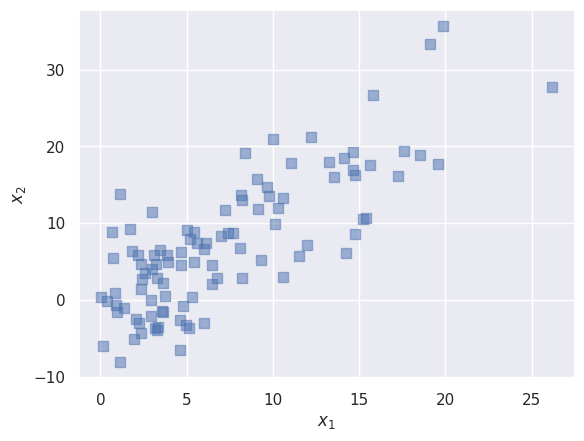

Variância x1 = 30.79428545290911
Variância x2 = 76.24938585795348


In [36]:
m = 100
np.random.seed(42)
x1 = 10.*np.sqrt((np.random.normal(size=m))**2)
x2 = x1 + 5.8*(np.random.normal(size=m))


plt.scatter(x1, x2, marker ="s", s = 50,alpha=0.5)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()
print("Variância x1 =",np.var(x1,ddof=1))
print("Variância x2 =",np.var(x2,ddof=1))


In [37]:
X = np.stack((x1,x2),axis=1)
print("As dimensões de X são",X.shape)
cov = np.cov(X.T, bias = False)
print("Matriz de covariância:")
pd.DataFrame([[cov[0][0], cov[0][1]],[cov[1][0], cov[1][1]]], index =("x1", "x2"), columns=['x1', 'x2'])


As dimensões de X são (100, 2)
Matriz de covariância:


,x1,x2
x1,30.794285,38.224306
x2,38.224306,76.249386


A matriz de correlação é calculada através do comando,
```
cor = np.corrcoef(X.T)
```




In [38]:
cov = np.cov(X.T)
print('Matriz de covariância :')
print(pd.DataFrame([[cov[0][0], cov[0][1]],[cov[1][0], cov[1][1]]], index =("x1", "x2"), columns=['x1', 'x2']))

print('\n Matriz de correlação :')
cor = np.corrcoef(X.T)
print(pd.DataFrame([[cor[0][0], cor[0][1]],[cor[1][0], cor[1][1]]], index =("x1", "x2"), columns=['x1', 'x2']))


Matriz de covariância :
           x1         x2
x1  30.794285  38.224306
x2  38.224306  76.249386

 Matriz de correlação :
          x1        x2
x1  1.000000  0.788835
x2  0.788835  1.000000


A matriz de correlação é obtida também se usarmos os valores de $\mathbf X$ padronizados, ié, subtrairmos sua média e dividirmos pelo seu desvio padrão.

In [39]:
X_std = StandardScaler().fit_transform(X)
cov = np.cov(X_std.T)
print('Matriz de covariância padronizada :')
print(pd.DataFrame([[cov[0][0], cov[0][1]],[cov[1][0], cov[1][1]]], index =("x1", "x2"), columns=['x1', 'x2']))


Matriz de covariância padronizada :
          x1        x2
x1  1.010101  0.796803
x2  0.796803  1.010101


### Base de um vetor

Matematicamente, para que um conjunto de vetores $\mathbf b_i$ seja linearmente independente, em um espaço 𝑛-dimensional, a expressão

$$
c_1 \mathbf b_1 + c_2 \mathbf b_2 + \cdots+ c_n \mathbf b_n=0
$$

deve ser possível apenas se todos os fatores lineares $c_i$ forem 0.
Em resumo, nenhum vetor pode ser expresso como uma combinação linear dos outros. Os vetores $\mathbf b_i$, portanto, formam uma base de dimensão $n$.

Por outro lado, cada amostra de dados é um vetor no espaço de dimensão $n$, onde $n$ é o número de características de uma amostra. Dessa forma, cada amostra é um vetor de um espaço vetorial de dimensão $n$, representado por uma base ortonormal.

Qualquer vetor de medição nesse espaço, ié, qualquer $\mathbf x^{(i)}$, é uma combinação linear desse conjunto de vetores básicos de comprimento unitário. Uma escolha simples e direta de uma base $\mathbf B$ é a matriz de identidade $\mathbf I$,
$$
\mathbf B=\left(\begin{array}{c}
\mathbf b_1 \\
\mathbf b_2 \\
\vdots \\
\mathbf b_n
\end{array}\right) =
\left(\begin{array}{cccc}
1 & 0 & \cdots & 0 \\
0 & 1 & \cdots & 0  \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & 1
\end{array}\right)
$$
onde cada linha $\mathbf b_i$ é uma base com $n$ componentes.

### Mudança de base

Dado o vetor $\mathbf X \in \mathbb{R}^{m \times n}$ de dados de entrada,
\begin{equation}
\mathbf X_{m,n} =
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1n} \\
x_{21} & x_{22} & \cdots & x_{2n} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{m1} & x_{m2} & \cdots & x_{m,n}
\end{pmatrix} =
\begin{pmatrix}
|  & |  &   & |  \\
\hat{\mathbf x}_{1} & \hat{\mathbf x}_{2} & \cdots & \hat{\mathbf x}_{n} \\
|  & |  &   & |  
\end{pmatrix}=
\begin{pmatrix}
-  & {\mathbf x}_{1}   & -  \\
 - & {\mathbf x}_{2}   & - \\
   & \vdots &    \\
 - & {\mathbf x}_{m} & -
\end{pmatrix}
\end{equation}

Define-se que as linhas representam diferentes observações e cada coluna refere-se a uma característica ou variável. Por exemplo, se medirmos peso e altura de $3$ pessoas nossa matriz $\mathbf X$ terá dimensão $(3,2)$, onde cada linha representa um dos 3 indivíduos e as duas colunas se referem às características peso e altura. Dessa forma, $x_{j1}$ seria o peso do $j-$ésimo indivíduo, $x_{k1}$ seria o peso do $k-$ésimo indivíduo e $x_{j2}$ seria a altura do $j-$ésimo indivíduo.

Define-se um vetor $\mathbf w_i$ de transformação
\begin{equation}
\mathbf w_{n,n} =
\begin{pmatrix}
|  & |  &   & |  \\
\mathbf w_{1} & \mathbf w_{2} & \cdots & \mathbf w_{n} \\
|  & |  &   & |  
\end{pmatrix}
\end{equation}
de forma que:
\begin{equation}
\mathbf Z_{m,n} = \mathbf X_{m,n} \mathbf w_{n,n} =  
\begin{pmatrix}
{\mathbf x}_{1}\mathbf w_{1}& {\mathbf x}_{1} \mathbf w_{2}  & \cdots & {\mathbf x}_{1} \mathbf w_{n}\\
{\mathbf x}_{2}\mathbf w_{1}& {\mathbf x}_{2} \mathbf w_{2}  & \cdots & {\mathbf x}_{2} \mathbf w_{n}\\
\vdots  & \vdots  & \ddots & \vdots  \\
{\mathbf x}_{m}\mathbf w_{1}& {\mathbf x}_{m} \mathbf w_{2}  & \cdots & {\mathbf x}_{m} \mathbf w_{n}\\
\end{pmatrix}
\end{equation}

Geometricamente, $\mathbf w_i$ é uma rotação e um alongamento que transforma $\mathbf X$ em $\mathbf Z$. A nova matriz $\mathbf Z$ pode ser definida como,

\begin{equation}
\mathbf Z_{m,n} =
\begin{pmatrix}
|  & |  &   & |  \\
\hat{\mathbf z}_{1} & \hat{\mathbf z}_{2} & \cdots & \hat{\mathbf z}_{n} \\
|  & |  &   & |  
\end{pmatrix}=
\begin{pmatrix}
-  & {\mathbf z}_{1}   & -  \\
 - & {\mathbf z}_{2}   & - \\
   & \vdots &    \\
 - & {\mathbf z}_{m} & -
\end{pmatrix}
\end{equation}
onde
\begin{equation}
\hat{\mathbf z}_i =
\begin{pmatrix}
{\mathbf x}_{1}\mathbf w_i \\
{\mathbf x}_{2}\mathbf w_i \\
\vdots   \\
{\mathbf x}_{m}\mathbf w_i
\end{pmatrix}, \qquad i=1,\cdots,n
\end{equation}
é a transformação das observações na direção $\mathbf w_i$, e
\begin{equation}
{\mathbf z}_i =
\begin{pmatrix}
{\mathbf x}_{i}\mathbf w_{1} & {\mathbf x}_{i}\mathbf w_{2} & \cdots  & {\mathbf x}_{i}\mathbf w_{n}
\end{pmatrix}
\end{equation}
é a transformação da observação $i$.


#### Exemplo



O ponto  $\mathbf x_b =[1 \quad 1]$, definido nas bases $\mathbf b_1 = [1 \quad 0]^T$ e $\mathbf b_2 = [0 \quad 1]^T$ pode ser escrito como,
$$
\mathbf x_b = x_{b_1} \left(\begin{array}{rr} 1\\ 0  \end{array}\right) + x_{b_2} \left(\begin{array}{rr} 0\\ 1  \end{array}\right) = 1 \left(\begin{array}{rr} 1\\ 0  \end{array}\right) + 1 \left(\begin{array}{rr} 0\\ 1  \end{array}\right) = \left(\begin{array}{rr} 1 & 1  \end{array}\right)\left(\begin{array}{rr}1 & 0\\ 0 & 1 \end{array}\right) = \left(\begin{array}{rr} 1 & 1  \end{array}\right).
$$

Para esse ponto $\mathbf x_b =[1 \quad 1]$, defina a matriz de transformação para os dois espaços mostrados na figura abaixo. No primeiro, $\mathbf b_1$ e $\mathbf b_2$ são duplicados de tamanho, e no segundo, são rotacionados $\theta = 30^o$.

<center><img src='https://drive.google.com/uc?export=view&id=1PwEQnwiyFdFbtqbCb6ZiqigQqitFVa-H' width="800"></center>

Para o primeiro caso, a matriz de transformação de base é dada por:
$$
\mathbf{W}_1 = \left(\begin{array}{rr}2 & 0\\ 0 & 2  \end{array}\right)
$$
isto é,
$$
\mathbf b'_1 = \left(\begin{array}{rr} 2\\ 0  \end{array}\right) = \left(\begin{array}{rr} 2 & 0\\ 0 & 2  \end{array}\right)\left(\begin{array}{rr} 1\\ 0  \end{array}\right)
$$
ou
$$
\mathbf b'_2 = \left(\begin{array}{rr} 0\\ 2  \end{array}\right) = \left(\begin{array}{rr} 2 & 0\\ 0 & 2  \end{array}\right)\left(\begin{array}{rr} 0\\ 1  \end{array}\right).
$$

Portanto, o vetor $\mathbf x_b$ escrito na nova base, ié, $\mathbf z$, fica:
$$
\left(\begin{array}{rr} 1 & 1  \end{array}\right)\left(\begin{array}{rr}1 & 0\\ 0 & 1 \end{array}\right) = \mathbf z  \mathbf{W}_1  = \left(\begin{array}{rr} z_{1} & z_{2}  \end{array}\right)  \left(\begin{array}{rr} 2 & 0 \\ 0  & 2 \end{array}\right)
$$

Se multiplicarmos ambos os lados da equação acima por $\mathbf{W}_1^{-1}$, e, sabendo que$^*$,
$$
\mathbf{W}_1^{-1} = \frac{1}{4} \left(\begin{array}{rr}2 & 0\\ 0 & 2  \end{array}\right)
$$
tem-se:
$$
\left(\begin{array}{rr} z_{1} & z_{2}  \end{array}\right)  = \left(\begin{array}{rr} 1 & 1  \end{array}\right) \frac{1}{4} \left(\begin{array}{rr}2 & 0\\ 0 & 2  \end{array}\right)  = \left(\begin{array}{rr} \frac{1}{2} & \frac{1}{2}  \end{array}\right).
$$

Para o segundo caso, lembre-se que a matriz de rotação bidimensional que gira os eixos no plano no sentido anti-horário através de um ângulo $\theta$ em torno da origem é definida como,

$$
\mathbf{R}_2 = \left(\begin{array}{rr}\cos\theta & -\sin\theta\\ \sin\theta & \cos\theta \end{array}\right).
$$

<small> *Caso você não lembre mais como se inverte uma matriz, use:
```
np.linalg.inv(np.array([[2,0],[0,2]]))
```
<small>


In [40]:
#Primeiro Caso
b1 = [1,0]
b2 = [0,1]
B = np.array([b1,b2])
W1 = 2*B

W1inv=np.linalg.inv(W1)
X=np.array([[1,1]])
Z1=np.dot(X,W1inv)
print(' Vetor z:\n',Z1)


 Vetor z:
 [[0.5 0.5]]


In [41]:
#@title Resposta do Segundo caso { display-mode: "form" }
#Segundo caso
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
W2 = np.array([[c,s], [-s, c]])
W2inv=W2.T
X=np.array([[1,1]])
Z2=np.dot(X,W2inv)
print(' Vetor z: \n',Z2)


 Vetor z: 
 [[1.3660254 0.3660254]]


Como conferir a resposta?

Bom, o vetor $\mathbf x_b =[1 \quad 1]$ quando escrito nas bases iniciais $\mathbf b_1$ e $\mathbf b_2$.
$$
\left(\begin{array}{rr} 1 & 1  \end{array}\right)\left(\begin{array}{rr}1 & 0\\ 0 & 1 \end{array}\right) = \mathbf z \mathbf{W}$$

Então, substitua os valores de $\mathbf w_i$ e $\mathbf z$ para cada transformação e veja se recupera o vetor $\mathbf x_b$ nas bases originais $\mathbf b_1$ e $\mathbf b_2$.

In [42]:
#Conferindo as respostas:
print('xb = [ {:f}  {:f}  ]'.format(Z1[0][0]*W1[0][0]+Z1[0][1]*W1[1][0],Z1[0][0]*W1[0][1]+Z1[0][1]*W1[1][1]))
print('xb = [ {:f}  {:f}  ]'.format(Z2[0][0]*W2[0][0]+Z2[0][1]*W2[1][0],Z2[0][0]*W2[0][1]+Z2[0][1]*W2[1][1]))


xb = [ 1.000000  1.000000  ]
xb = [ 1.000000  1.000000  ]


### Onde estamos

Definimos a análise de componentes principais (PCA) como uma técnica estatística fundamental usada para reduzir a dimensionalidade de um conjunto de dados, enquanto preserva o máximo de variação possível. *Maior variação possível* está conectada a conceitos-chave que estudamos: variância e covariância:

* __Variância__ A variância $s_{ii}$ mede a dispersão da característica $i$ em torno da média do conjunt de dados. Em outras palavras, indica o quanto a característica *se espalha*. No PCA, a variância é crucial porque a técnica busca identificar direções (componentes principais) ao longo das quais a variabilidade dos dados é máxima. Ao maximizar a variância, a PCA garante que os componentes principais capturam a maior parte da informação contida nos dados originais. Componentes com maior variância são considerados mais importantes porque explicam mais da estrutura dos dados.

* __Covariância__ A covariância $s_{ij}$ mede a relação entre duas características $i$ e $j$. Especificamente, ela indica se as características tendem a aumentar e diminuir juntas (covariância positiva) ou se uma tende a aumentar quando a outra diminui (covariância negativa). A covariância é importante no PCA porque revela a medida em que duas características mudam juntas. Se as características estão fortemente correlacionadas, o PCA pode combiná-las em um componente principal, reduzindo assim a dimensionalidade.

* __Matriz de Covariância__ No PCA, a matriz de covariância dos dados é calculada para entender as relações entre todas as características. A matriz de covariância é usada para identificar as direções de maior variância e as direções em que os dados estão mais correlacionados. As direções dos componentes principais são, na verdade, os autovetores da matriz de covariância, e os valores que indicam a quantidade de variância explicada em cada direção são os autovalores. Mas isso já é spoiler...

$$
\mathbf S = \begin{pmatrix}
\color{palevioletred}{s_{11}} & \color{skyblue}{s_{12}} & \cdots & \color{skyblue}{s_{1n}} \\
\color{skyblue}{s_{21}} & \color{palevioletred}{s_{22}} & \cdots & \color{skyblue}{s_{2n}} \\
\vdots & \vdots & \ddots & \vdots \\
\color{skyblue}{s_{n1}} & \color{skyblue}{s_{n2}} & \cdots & \color{palevioletred}{s_{nn}}
\end{pmatrix}
$$

E porque recordamos mudança de base?

Bom, a  mudança de base é um conceito matemático que se refere à transformação dos dados para um novo sistema de coordenadas. No PCA, os dados são projetados em um novo conjunto de eixos que são as direções dos componentes principais. Esses novos eixos são ortogonais entre si e correspondem aos autovetores da matriz de covariância (outro spoiler). A mudança de base facilita a interpretação dos dados, pois as primeiros componentes principais capturam a maior parte da variabilidade dos dados, permitindo a redução da dimensionalidade sem perder informação significativa. Ao projetar os dados nas primeiras poucas componentes principais, é possível visualizar e analisar dados complexos de maneira mais simples e intuitiva.

<center><img src='https://drive.google.com/uc?export=view&id=1W6RDvrbIsplbi5x0Fqtt_F7HdzJ2I4kS' width="800"></center>

<center><img src='https://drive.google.com/uc?export=view&id=18X6gd0Iop0LN8rQUKpwGmtJtiuoFONFH' width="400"></center>


Uma característica importante de autovalores e autovetores de uma matriz simétrica, que aprendemos ao estudarmos SVD: os autovalores e autovetores representam as direções e dimensões de máxima variância da transformação.

<center><img src='https://drive.google.com/uc?export=view&id=153VU5KvJfBDjbLqM7WENSKGrkRH9CMvq' width="600"></center>


# PCA e os autovalores e autovetores

Para fazer a análise de componentes principais, precisamos encontrar os *componentes*, e isso requer a busca de *autovetores* para a matriz de covariância do conjunto de dados.

### Autovalores e autovetores

Em inglês, autovalores e autovetores chamam-se, respectivamente, *eigenvalues* e *eigenvectors*. Mas, a palavra original é alemã, *eigen*, e significa *próprio, peculiar*. Mas, isso não explica muito. É uma curiosidade.

Os autovetores de uma matriz de covariância são chamados direções principais, pois correspondem às direções da variância máxima. As projeções dos dados nas direções principais são conhecidas como componentes principais.
Daí o nome Análise de Componentes Principais.

Quanto maior o autovalor,  maior a quantidade de variação capturada por aquela componente principal. A variância capturada ao longo de cada CP pode ser calculada pela variância da projeção dos dados na direção principal.

#### Definição de autovalor e autovetor

Dado um operador linear $ {\bf A} $ com dimensões $ n \times n $, existe um conjunto de $n$ vetores $ \bf {v}_i $, cada um com a dimensão $n$, de modo que a multiplicação de qualquer um desses vetores por $ {\bf A } $ resulta em um vetor paralelo a $ \bf {v} _i $, com um comprimento multiplicado por uma constante $ \lambda_i $,

$$ {\bf A} \bf {v} _i = \lambda_i \bf {v}_i $$

onde $ \lambda_i $ são os *autovalores* e os vetores $ \bf {v}_i $ são os *autovetores*.

**Importante: autovalores e autovetores são uma característica da matriz ${\bf A}$.** O número de autovalores e autovetores é igual ao rank da matriz.

Use a biblioteca `numpy` para calcular autovalores e autovetores da matriz de covariância que estamos usando como exemplo.
```
autovalores, autovetores = np.linalg.eig(cov)
```
Veja que os autovetores são as colunas da matriz `autovetores`, e referem-se aos autovalores listados no vetor `autovalores`.

In [43]:
autovalores, autovetores = np.linalg.eig(cov)
print('Autovalores:\n',autovalores)
print('Autovetores:\n',autovetores)
print('Autovalor 1: ',autovalores[0],'Autovetor 1:', autovetores[:,0])
print('Autovalor 2: ',autovalores[1],'Autovetor 2:', autovetores[:,1])


Autovalores:
 [1.80690441 0.21329761]
Autovetores:
 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
Autovalor 1:  1.8069044101209237 Autovetor 1: [0.70710678 0.70710678]
Autovalor 2:  0.21329761008109627 Autovetor 2: [-0.70710678  0.70710678]


Os autovalores no PCA informam quanta variância pode ser explicada por seu autovetor associado. Daí o nome *variância explicada*. Portanto, o maior autovalor indica que a maior variância nos dados foi observada na direção de seu autovetor. Consequentemente, se você juntar todos os autovetores, poderá explicar toda a variação na amostra de dados.

Em vez de usar o valor absoluto da *variância explicada*, conforme indicado pelo autovalor, você também pode obter números relativos primeiro somando todos os autovalores e depois dividindo cada autovalor $\lambda_i$ por esta soma.


Se ordenarmos os autovalores $\lambda_i$ e as direções principais $\mathbf v_i$ de forma decrescente em relação ao autovalor $\lambda_i$, isso quer dizer que as primeiras componentes principais serão aquelas mais importantes com respeito à *quantidade de variação capturada*.

A classe abaixo foi adaptada do [link](https://github.com/Marcussena/ML-and-Ai-from-scratch/blob/main/PCA/pca.py).

In [44]:
class PCA:
    # https://github.com/Marcussena/ML-and-Ai-from-scratch/blob/main/PCA/pca.py
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance = None

    def fit(self, X):
        #1: Padronização dos dados (subtraia a média)
        self.mean = np.mean(X, axis=0)
        Xc = X - self.mean

        #2: Cálculo da matriz de covariância
        cov_matrix = np.cov(Xc.T)

        #3: Cálculo dos autovalores e autovetores
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        #4: Ordenação dos autovalores e autovetores correspondentes
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # 5: Seleção das top n_components
        self.components = eigenvectors[:, :self.n_components]

        # Cálculo da variância explicada
        total_variance = np.sum(eigenvalues)
        self.explained_variance = eigenvalues[:self.n_components] / total_variance

    def transform(self, X):
        # 6: Projeção dos dados nas componentes selecionadas
        Xc = X - self.mean
        return np.dot(Xc, self.components)

    def plot_explained_variance(self):
        # Criação de rótulos para cada componente principal
        labels = [f'PCA{i+1}' for i in range(self.n_components)]

        # Criação de um gráfico de barras para variação explicada
        plt.figure(figsize=(8, 6))
        plt.bar(range(1, self.n_components + 1), self.explained_variance, alpha=0.7, align='center', color='blue', tick_label=labels)
        plt.xlabel('Componente Principal')
        plt.ylabel('Razão de Variância Explicada')
        plt.title('Variância explicada por componentes principais')
        plt.show()


In [45]:
np.random.seed(42)

low_dim_data = np.random.randn(100, 4) # sinal de baixa dimensão
projection_matrix = np.random.randn(4, 10) # matriz de projeção aleatória para projetar em dimensões superiores
high_dim_data = np.dot(low_dim_data, projection_matrix) # Projeção dos dados de baixa dimensão para dimensões superiores
noise = np.random.normal(loc=0, scale=0.5, size=(100, 10)) #  Ruído
data_with_noise = high_dim_data + noise # Addição de ruído aos dados de alta dimensão

X = data_with_noise
print(X.shape)


(100, 10)


Variância explicada:
 [0.55405589 0.25223221 0.11137198 0.05298214 0.0064076  0.00625557
 0.00510674 0.00441098 0.00401037 0.00316652]


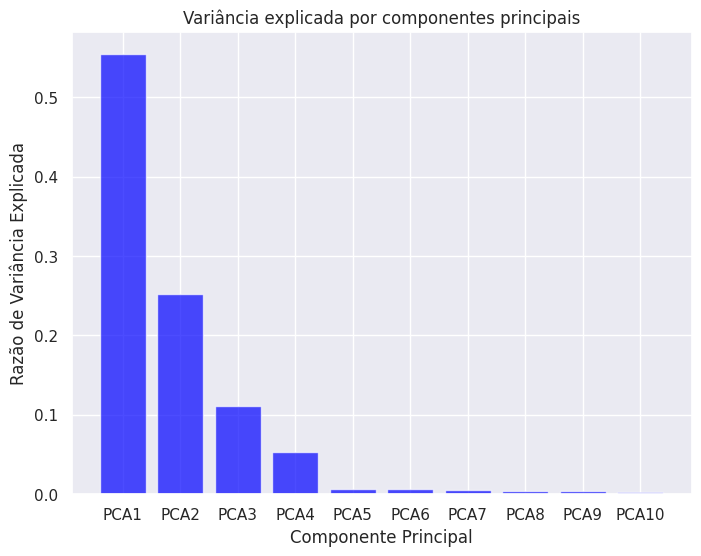

In [46]:
# PCA
pca = PCA(n_components=10)
pca.fit(X)
X_transformed = pca.transform(X)

print("Variância explicada:\n", pca.explained_variance)
pca.plot_explained_variance()


In [47]:
# PCA
pca = PCA(n_components=3)
pca.fit(X)
X_transformed = pca.transform(X)

print("Variância explicada:\n", pca.explained_variance)
pca.plot_explained_variance


Variância explicada:
 [0.55405589 0.25223221 0.11137198]


<bound method PCA.plot_explained_variance of <__main__.PCA object at 0x710317425870>>

<center><img src='https://drive.google.com/uc?export=view&id=15futtT5ZCa2OKSjnn6jl91ADIW_BdFfi' width="600"></center>

O PCA, portanto, nada mais é que a decomposição em autovalores da matriz de covariância. Mas decomposição em autovalores pode ser bem ineficiente e, na prática, o PCA é calculado usando Decomposição em Valores Singulares (SVD, do inglês *Singular Value Decomposition*).

# PCA e SVD

Toda matriz simétrica quadrada $\mathbf A $ pode ser diagonalizada através de seus autovalores e autovetores,

$$
\mathbf A = \mathbf V \mathbf \Lambda \mathbf V^T = \sum_{i = 1}^n \lambda_i \mathbf v_i \mathbf v_i^T
$$
sendo que $\mathbf v_i \perp \mathbf v_j, i\neq j$ e $\| \mathbf v_i \| = \mathbf v_i^T \mathbf v_i = 1$

A decomposição pode ser explicitada como:

\begin{equation}
\mathbf A_{n \times n} =
\begin{pmatrix}
|  & |  &   & |  \\
\mathbf v_{1} & \mathbf v_{2} & \cdots & \mathbf v_{n} \\
|  & |  &   & |  
\end{pmatrix}
\begin{pmatrix}
\lambda_1 & 0 & \cdots & 0 \\
0 & \lambda_2 & \cdots & 0 \\
\vdots & \vdots & \ddots &\vdots \\
0 & 0 & \cdots & \lambda_n
\end{pmatrix} \begin{pmatrix}
-  & \mathbf v_{1}^T  & -  \\
- & \mathbf v_{2}^T & - \\
  & \vdots   &    \\
- & \mathbf v_{n}^T & -
\end{pmatrix}
\end{equation}

In [48]:
A = np.array([[4, 1],
              [1, 3]])
lam, v = np.linalg.eig(A)
print("autovalores=", np.round(lam, 4))
print("autovetores=", np.round(v, 4))
Diag=np.array([[lam[0], 0],[0, lam[1]]])
print(v @ Diag @ v.T)


autovalores= [4.618 2.382]
autovetores= [[ 0.8507 -0.5257]
 [ 0.5257  0.8507]]
[[4. 1.]
 [1. 3.]]


In [49]:
A = array([[ 5, 18, 17],
           [18, 11,  3],
           [17, 3,  8]])
print('A matriz A:')
print(A)
# SVD
V, Sigma, _ = np.linalg.svd(A)
print('Autovalores:')
print(Sigma)
print('Autovetores:')
print(V)


A matriz A:
[[ 5 18 17]
 [18 11  3]
 [17  3  8]]
Autovalores:
[33.87457039 16.28981599  6.4152456 ]
Autovetores:
[[-0.65049364  0.75767825  0.05274176]
 [-0.57669419 -0.44753605 -0.68347297]
 [-0.49424876 -0.47501068  0.728068  ]]


A matriz $\mathbf{A}$ pode ser decomposta em $n$ matrizes $\mathbf{v}_i\mathbf{v}_i^T$ $n \times n$ ponderadas pelos autovalores $\lambda_i$:
$$
\mathbf{A} = \sum_{i=1}^n \lambda_i \mathbf{v}_i\mathbf{v}_i^T
$$
ou
$$
\mathbf{A} = \lambda_1 \mathbf{v}_1\mathbf{v}_1^T+\lambda_2 \mathbf{v}_2\mathbf{v}_2^T+\cdots + \lambda_n \mathbf{v}_1\mathbf{v}_n^T
$$

Como $\mathbf{u}_i$ são vetores unitários, podemos até ignorar termos $\lambda_i \mathbf{v}_i\mathbf{v}_i^T$ com $\lambda_i$ pequeno.


O código abaixo reconstrói a matriz $\mathbf A$ com o número de componentes $\mathbf v_i \mathbf v_i^T$ necessárias para atingir um limite mínimo de variância explicada definido pela variável `variance_threshold`, cujo padrão é $80\%$.

In [50]:
def svd_reconstruction_with_variance(matrix, variance_threshold=0.80):
    if np.all(matrix-matrix.T==0) == False:
        raise ValueError("Matriz deve ser simétrica")

    # Cálculo do SVD
    V, Lambda, VT = np.linalg.svd(matrix)

    # Cálculo da variância total
    total_variance = np.sum(Lambda)

    # Número de valores singulares necessários para alcançar o limite mínimo de variância dos dados
    variance_sum = 0
    num_singular_values = 0
    variances = []
    for i in range(len(Lambda)):
        variance_sum += Lambda[i]
        variances.append(variance_sum / total_variance)
        if variance_sum / total_variance >= variance_threshold:
            num_singular_values = i + 1
            break

    # Uso apenas dos principais valores singulares definido em 'num_singular_values' para reconstruir a matriz
    V_reduced = V[:, :num_singular_values]
    Lambda_reduced = np.diag(Lambda[:num_singular_values])
    VT_reduced = VT[:num_singular_values, :]

    # Reconstruct the matrix
    reconstructed_matrix = np.dot(V_reduced, np.dot(Lambda_reduced, VT_reduced))

    return reconstructed_matrix, num_singular_values, variances


In [51]:
A = np.array([[4, 1],
              [1, 3]])
variance_threshold = 0.6
Ar, num_singular_values, variances = svd_reconstruction_with_variance(A, variance_threshold)

print("Matriz original:")
print(A)
print("\nMatriz reconstruída com {:.0f}% de variância:".format(variance_threshold*100))
print(Ar)
print("\nNúmero de valores singulares usados:")
print(num_singular_values)

print("\nPorcentagem acumulada da variância total de cada valor singular utilizado:")
print(variances)


Matriz original:
[[4 1]
 [1 3]]

Matriz reconstruída com 60% de variância:
[[3.34164079 2.06524758]
 [2.06524758 1.2763932 ]]

Número de valores singulares usados:
1

Porcentagem acumulada da variância total de cada valor singular utilizado:
[0.659719141249985]


In [52]:
N = 10
np.random.seed(42)
A = np.random.random(size=(N,N))
A_symm = (A + A.T)/2
print(A_symm)


[[0.37454012 0.4856494  0.67192342 0.60310167 0.13902844 0.56278957
  0.22338045 0.81921046 0.73210922 0.41383341]
 [0.4856494  0.96990985 0.48596825 0.19143162 0.33850094 0.47926867
  0.28779564 0.36173606 0.52762157 0.50223696]
 [0.67192342 0.48596825 0.29214465 0.21570672 0.24522925 0.86233745
  0.51420565 0.25987828 0.4616563  0.40361773]
 [0.60310167 0.19143162 0.21570672 0.94888554 0.93747622 0.85161235
  0.33068355 0.45656677 0.37389569 0.50071485]
 [0.13902844 0.33850094 0.24522925 0.93747622 0.25877998 0.63021113
  0.29632279 0.61346268 0.4288463  0.47791082]
 [0.56278957 0.47926867 0.86233745 0.85161235 0.63021113 0.92187424
  0.31559429 0.46249502 0.18520531 0.40956296]
 [0.22338045 0.28779564 0.51420565 0.33068355 0.29632279 0.31559429
  0.14092422 0.78673366 0.40207841 0.75480988]
 [0.81921046 0.36173606 0.25987828 0.45656677 0.61346268 0.46249502
  0.78673366 0.07404465 0.4980116  0.27170504]
 [0.73210922 0.52762157 0.4616563  0.37389569 0.4288463  0.18520531
  0.40207841

In [53]:
var_threshold = 0.6
A_symm_r, num_singular_values, variances = svd_reconstruction_with_variance(A_symm, var_threshold)

print("Matriz original:")
print(A_symm)
print("\nMatriz reconstruída com {:.0f}% de variância:".format(var_threshold*100))
print(A_symm_r)
print("\nNúmero de valores singulares usados:")
print(num_singular_values)

print("\nPorcentagem acumulada da variância total de cada valor singular utilizado:")
print(variances)


Matriz original:
[[0.37454012 0.4856494  0.67192342 0.60310167 0.13902844 0.56278957
  0.22338045 0.81921046 0.73210922 0.41383341]
 [0.4856494  0.96990985 0.48596825 0.19143162 0.33850094 0.47926867
  0.28779564 0.36173606 0.52762157 0.50223696]
 [0.67192342 0.48596825 0.29214465 0.21570672 0.24522925 0.86233745
  0.51420565 0.25987828 0.4616563  0.40361773]
 [0.60310167 0.19143162 0.21570672 0.94888554 0.93747622 0.85161235
  0.33068355 0.45656677 0.37389569 0.50071485]
 [0.13902844 0.33850094 0.24522925 0.93747622 0.25877998 0.63021113
  0.29632279 0.61346268 0.4288463  0.47791082]
 [0.56278957 0.47926867 0.86233745 0.85161235 0.63021113 0.92187424
  0.31559429 0.46249502 0.18520531 0.40956296]
 [0.22338045 0.28779564 0.51420565 0.33068355 0.29632279 0.31559429
  0.14092422 0.78673366 0.40207841 0.75480988]
 [0.81921046 0.36173606 0.25987828 0.45656677 0.61346268 0.46249502
  0.78673366 0.07404465 0.4980116  0.27170504]
 [0.73210922 0.52762157 0.4616563  0.37389569 0.4288463  0.1852

E quando amatriz não é simétrica?

Dada uma matriz $\mathbf A \in \mathbb{R}^{m \times n}$, podemos calcular a decomposição SVD como:

$$
\mathbf A = \mathbf U \boldsymbol \Sigma \mathbf V^T
$$

As colunas das matrizes $\mathbf U$ e $\mathbf V$ são formadas pelos autovetores de $\mathbf A \mathbf A^T$ e $\mathbf A^T \mathbf A$, respectivamente.

A matriz diagonal $\boldsymbol \Sigma$ é composta dos autovalores $\sigma_i$ da matriz $\mathbf A \mathbf A^T$ ou $\mathbf A^T \mathbf A$. O valor $\sigma_i$ é conhecido como valor singular.

Importante relembrar que os autovalores $\lambda_i$ de $\mathbf A$ se relacionam com $\sigma_i$ de modo que:

$$\sigma_i = \sqrt{\lambda_i}$$

In [54]:
A = np.random.rand(10, 2)
print(A)


[[0.03142919 0.63641041]
 [0.31435598 0.50857069]
 [0.90756647 0.24929223]
 [0.41038292 0.75555114]
 [0.22879817 0.07697991]
 [0.28975145 0.16122129]
 [0.92969765 0.80812038]
 [0.63340376 0.87146059]
 [0.80367208 0.18657006]
 [0.892559   0.53934224]]


In [55]:
variance_threshold=0.80
A_reduced, num_singular_values, variances = svd_reconstruction_with_variance(A,variance_threshold)

print("Matriz original:")
print(A)
print("\nMatriz reconstruída com {:0.0f}% de variância:".format(variance_threshold*100))
print(A_reduced)
print("\nNúmero de valores singulares usados:")
print(num_singular_values)

print("\nPorcentagem acumulada da variância total de cada valor singular utilizado:")
print(variances)


ValueError: operands could not be broadcast together with shapes (10,2) (2,10) 

In [56]:
def svd_reconstruction_with_variance(matrix, variance_threshold=0.80):
    # Cálculo do SVD
    U, Sigma, VT = np.linalg.svd(matrix, full_matrices=False)

    # Cálculo da variância total (soma dos valores singulares ao quadrado)
    total_variance = np.sum(Sigma**2)

    # Número de valores singulares necessários para alcançar
    # o limite mínimo de variância dos dados
    variance_sum = 0
    num_singular_values = 0
    variances = []
    for i in range(len(Sigma)):
        variance_sum += Sigma[i]**2
        variances.append(variance_sum / total_variance)
        if variance_sum / total_variance >= variance_threshold:
            num_singular_values = i + 1
            break

    # Uso apenas dos principais valores singulares definido em
    # 'num_singular_values' para reconstruir a matriz
    U_reduced = U[:, :num_singular_values]
    Sigma_reduced = np.diag(Sigma[:num_singular_values])
    VT_reduced = VT[:num_singular_values, :]

    # Reconstrução da Matriz
    reconstructed_matrix = np.dot(U_reduced, np.dot(Sigma_reduced, VT_reduced))

    return reconstructed_matrix, num_singular_values, variances


In [57]:
variance_threshold=0.80
A_reduced, num_singular_values, variances = svd_reconstruction_with_variance(A,variance_threshold)

print("Matriz original:")
print(A)
print("\nMatriz reconstruída com {:0.0f}% de variância:".format(variance_threshold*100))
print(A_reduced)
print("\nNúmero de valores singulares usados:")
print(num_singular_values)

print("\nPorcentagem acumulada da variância total de cada valor singular utilizado:")
print(variances)


Matriz original:
[[0.03142919 0.63641041]
 [0.31435598 0.50857069]
 [0.90756647 0.24929223]
 [0.41038292 0.75555114]
 [0.22879817 0.07697991]
 [0.28975145 0.16122129]
 [0.92969765 0.80812038]
 [0.63340376 0.87146059]
 [0.80367208 0.18657006]
 [0.892559   0.53934224]]

Matriz reconstruída com 80% de variância:
[[0.33240198 0.28341153]
 [0.43311592 0.36928193]
 [0.64860805 0.55301415]
 [0.61065764 0.52065698]
 [0.17049225 0.14536457]
 [0.24737837 0.21091897]
 [0.93732277 0.79917718]
 [0.79702445 0.67955647]
 [0.55748099 0.47531768]
 [0.78311879 0.66770027]]

Número de valores singulares usados:
1

Porcentagem acumulada da variância total de cada valor singular utilizado:
[0.8926462681796792]


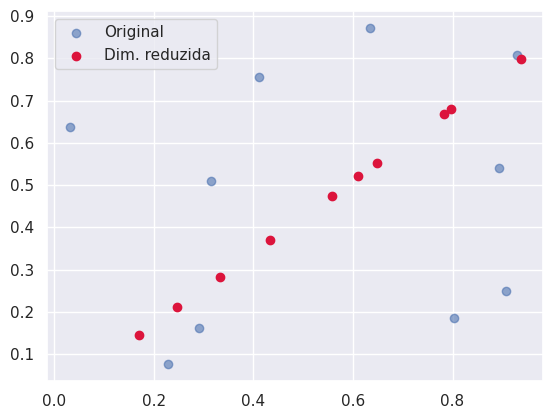

In [58]:
# Plotar dados originais/dados reduzidos
plt.scatter(A[:, 0], A[:, num_singular_values], alpha = 0.6, label = 'Original')
plt.scatter(A_reduced[:, 0], A_reduced[:, num_singular_values], c='crimson', label = 'Dim. reduzida')
plt.legend()
plt.show()


Voltando ao nosso problema, a matriz de covariância é simétrica e pode ser, portanto, decomposta em autovalores
$$
\mathbf S = \frac{1}{m-1}\mathbf X_c^T \mathbf X_c = \mathbf V \mathbf \Lambda \mathbf V^T
$$
ou
$$
\mathbf S =\sum_{i = 1}^m \lambda_i \mathbf v_i \mathbf v_i^T
$$

Os autovetores $\mathbf v_i$ são chamados de eixos principais ou direções principais dos dados.

Portanto, a matriz $\mathbf S$ pode ser decomposta em $n$ matrizes $\mathbf v_i \mathbf v_i^T$ $n\times n$, ponderadas de $\lambda_i$, onde $\mathbf v_{i}$ são os $n$ autovetores de $\mathbf S$ e $\lambda_i$ os respectivos autovalores distribuídos na matriz diagonal $\mathbf \Lambda$.


Veja que, se transformamos o vetor de dados da seguinte forma:
$$
\mathbf Z=\mathbf X_c\mathbf V
$$
basta multiplicar o conjunto de dados, após centralizado, pela matriz de autovetores encontrada na decomposição da matriz de covariância.

Essa transformação $\mathbf Z=\mathbf X_c\mathbf V$ leva a uma matriz de covariância,
\begin{equation}
\mathbf S_Z
= {1 \over {m-1}}\mathbf Z^T \mathbf Z
\end{equation}

Portanto,
\begin{equation}\begin{array}{cl}
\mathbf S_z & = {1 \over {m-1}}\left(\mathbf X_c\mathbf V\right)^T \left(\mathbf X_c \mathbf V\right) \\
& = {1 \over {m-1}}\mathbf V^T \mathbf X_c^T \mathbf X_c \mathbf V \\
&   = {1 \over {m-1}}\mathbf V^T \left(\mathbf X_c^T \mathbf X_c\right) \mathbf V \\
& = \mathbf V^T \mathbf S \mathbf V \\
\end{array}
\end{equation}
onde $\mathbf S=\frac{1}{m-1}\mathbf X_c^T \mathbf X_c$ que, conforme aprendemos, pode ser decomposta em $\mathbf S=\mathbf V \mathbf \Lambda \mathbf V^T$,
\begin{equation}\begin{array}{cl}
\mathbf S_z & = \mathbf V^T\left(\mathbf V\mathbf \Lambda \mathbf V^T \right) \mathbf V \\
& = \left(\mathbf V^T\mathbf V\right)\mathbf \Lambda \left(\mathbf V^T \mathbf V \right)\\
& = \mathbf \Lambda \\
\end{array}
\end{equation}
sabendo-se que o vetor $\mathbf V^T=\mathbf V^{-1}$.Portanto,
$$
\mathbf S_z =\mathbf \Lambda \tag{1}
$$

Dessa forma,  $\mathbf S_z$ é diagonal, e esse era outro objetivo do PCA!!! Além da máxima variância, lembre-se que estamos procurando uma transformação com a covariância mínima possível, que é zero. Então, o ideal é que $\mathbf S_z$ seja uma matriz diagonal.  Que foi exatamente o que encontramos. O i-ésimo valor diagonal de $\mathbf S_z$ é a variância de $\mathbf X$ ao longo de $\mathbf v_i$.


Se agora aplicarmos a decomposição de valor singular (SVD) à matriz de dados centralizada $\mathbf X_c$, obteremos uma decomposição,
$$
\mathbf X_c=\mathbf U\mathbf \Sigma\mathbf V^T
$$
onde $\mathbf \Sigma$ é a matriz diagonal que possui os autovalores $\sigma_i$ de $\mathbf X_c$. Os autovetores de $\mathbf X_c\mathbf X_c^𝑇$ formam as colunas da matriz $\mathbf U$, e os autovetores de $\mathbf X_c^T\mathbf X_c$ formam as colunas da matriz $\mathbf V$ (vejam que essa matriz $\mathbf V$ já foi definida anteriormente na decomposição em autovalores) .

Tentando construir a matriz de covariância a partir desta decomposição tem-se
$$
\mathbf S = \frac{1}{m-1}\mathbf X_c^T\mathbf X_c
=\frac{1}{m-1}(\mathbf U\mathbf \Sigma\mathbf V^T)^T(\mathbf U\mathbf \Sigma\mathbf V^T)
= \frac{1}{m-1}(\mathbf V\mathbf \Sigma\mathbf U^T)(\mathbf U\mathbf \Sigma\mathbf V^T)
$$
e como $\mathbf U^T \mathbf U=\mathbf I$,
$$
\mathbf S =\frac{1}{m-1}\mathbf X_c^T\mathbf X_c=\frac{1}{m-1}\mathbf V\mathbf \Sigma^2 \mathbf V^T \mathbf =\mathbf V \mathbf \Lambda \mathbf V^T
$$
e a correspondência é facilmente vista. Por exemplo, as raízes quadradas dos autovalores de $\mathbf X_c^T\mathbf X_c$ são os valores singulares de $\mathbf X_c$,
$$
\mathbf \Lambda = \frac{1}{m-1}\mathbf \Sigma^2
$$

significando que os vetores singulares à direita $\mathbf V$ são direções principais e que os valores singulares estão relacionados aos autovalores da matriz de covariância via
$$\lambda_i = \frac{\sigma_i^2}{m−1}. \tag{2}$$

Dessa forma, é possível, sem criar a matriz de covariância, achar as componentes principais.

### Exemplo

Para a matriz do conjunto de dados $\mathbf X$
\begin{equation}
\mathbf X = \begin{bmatrix}
3 & 4 & 3 & 1\\
1 & 3 & 2 & 6\\
2 & 4 & 1 & 5\\
3 & 3 & 5 & 2
\end{bmatrix}
\end{equation}

de modo que,

$$
\mathbf S = \frac{1}{n-1}\mathbf X_c^T\mathbf X_c=\mathbf V\mathbf \Lambda \mathbf V^T
$$

Plote a variância relacionada às componentes principais.

In [59]:
X = np.matrix([[3, 4, 3, 1],[1,3,2,6],[2,4,1,5],[3,3,5,2]])
m,n = X.shape
print(m,n)


4 4


In [60]:
cov = np.cov(X.T)
print(f'Matriz de Covariância:\n {cov}')


Matriz de Covariância:
 [[ 0.91666667  0.16666667  1.08333333 -2.16666667]
 [ 0.16666667  0.33333333 -0.5        -0.33333333]
 [ 1.08333333 -0.5         2.91666667 -2.83333333]
 [-2.16666667 -0.33333333 -2.83333333  5.66666667]]


In [61]:
# calcula a média de cada coluna
xbar = np.mean(X, axis = 0).T
#gera um vetor de 1s
Vet1 = np.ones((m,1))
#subtrai de cada coluna de A sua respectiva média
Xc = X - np.outer(Vet1,xbar)
print(f'Matriz X centralizada:\n {Xc}')


Matriz X centralizada:
 [[ 0.75  0.5   0.25 -2.5 ]
 [-1.25 -0.5  -0.75  2.5 ]
 [-0.25  0.5  -1.75  1.5 ]
 [ 0.75 -0.5   2.25 -1.5 ]]


In [62]:
V, lambdai, _ = np.linalg.svd(cov)
Lambda = np.diag(lambdai)
print(f'Matriz Diagonal com autovalores da matriz de Covariância:\n {Lambda}')


Matriz Diagonal com autovalores da matriz de Covariância:
 [[8.23690504e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.51165390e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.47743887e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90563191e-17]]


In [63]:
print(f'Variância através da matriz X centralizada Xc:\n {np.dot(Xc.T,Xc)/(m-1)}')
print(f'Variância através de autovetores:\n {np.dot(np.dot(V,Lambda),V.T)}')


Variância através da matriz X centralizada Xc:
 [[ 0.91666667  0.16666667  1.08333333 -2.16666667]
 [ 0.16666667  0.33333333 -0.5        -0.33333333]
 [ 1.08333333 -0.5         2.91666667 -2.83333333]
 [-2.16666667 -0.33333333 -2.83333333  5.66666667]]
Variância através de autovetores:
 [[ 0.91666667  0.16666667  1.08333333 -2.16666667]
 [ 0.16666667  0.33333333 -0.5        -0.33333333]
 [ 1.08333333 -0.5         2.91666667 -2.83333333]
 [-2.16666667 -0.33333333 -2.83333333  5.66666667]]


In [64]:
cp = V
Z = np.dot(Xc,cp)
print(f'Projeção de Xc nas direções principais (componentes principais):\n{Z}')


Projeção de Xc nas direções principais (componentes principais):
[[-2.38993763e+00 -1.16505941e+00  2.36293682e-01  8.32667268e-17]
 [ 2.79391217e+00  8.66460644e-01  2.61344083e-01  2.49800181e-16]
 [ 2.15506283e+00 -9.42090469e-01 -3.05237231e-01 -2.77555756e-17]
 [-2.55903737e+00  1.24068924e+00 -1.92400534e-01 -3.05311332e-16]]


## Análise da matriz de covariância

Os autovetores $\mathbf v_i$ são chamados de eixos principais ou direções principais dos dados. As projeções dos dados nos eixos principais são chamadas de *componentes principais*, também conhecidas como *PC scores*; estas podem ser vistas como as novas variáveis transformadas.

A j-ésima componente principal é dada pela j-ésima coluna de $\mathbf X_c \mathbf V $. As coordenadas do i-ésimo ponto de dados no novo espaço PC são dadas pela i-ésima linha de $\mathbf X_c \mathbf V $.

In [65]:
U, sigmai, Vt = np.linalg.svd(Xc)
Sigma = np.diag(sigmai)
print(f'Matriz Diagonal com autovalores de Xc:\n {Sigma}')


Matriz Diagonal com autovalores de Xc:
 [[4.97098734 0.         0.         0.        ]
 [0.         2.12954495 0.         0.        ]
 [0.         0.         0.50430464 0.        ]
 [0.         0.         0.         0.        ]]


Perceba que os autovalores $\sigma_i$ são resultado da decomposição em valor singular do vetor $\mathbf{X}_c$, enquanto que os autovalores $\lambda_i$ referem-se à decomposição em autovalores da matriz de covariância. Eles estão relacionados da seguinte forma:
$$\lambda_i = \frac{\sigma_i^2}{m−1}.$$

São os autovalores da matriz de covariância $\lambda_i$ que mostram as variâncias das respectivas PCs.

Compare o primeiro autovalor $\lambda_1=8.23690504$ com:

In [66]:
4.97098734**2/(m-1)


8.236905044813424

In [67]:
print(f'Variância através de autovetores e autovalores de Xc:\n {np.dot(np.dot(Vt.T,Sigma**2),Vt)/(m-1)}')


Variância através de autovetores e autovalores de Xc:
 [[ 0.91666667  0.16666667  1.08333333 -2.16666667]
 [ 0.16666667  0.33333333 -0.5        -0.33333333]
 [ 1.08333333 -0.5         2.91666667 -2.83333333]
 [-2.16666667 -0.33333333 -2.83333333  5.66666667]]


In [68]:
# conforme a teoria, Z pode ser calculado também como,
print(f'Pode ser também calculada como U*Sigma:\n{np.dot(U,Sigma)}')


Pode ser também calculada como U*Sigma:
[[-2.38993763  1.16505941 -0.23629368  0.        ]
 [ 2.79391217 -0.86646064 -0.26134408  0.        ]
 [ 2.15506283  0.94209047  0.30523723  0.        ]
 [-2.55903737 -1.24068924  0.19240053  0.        ]]


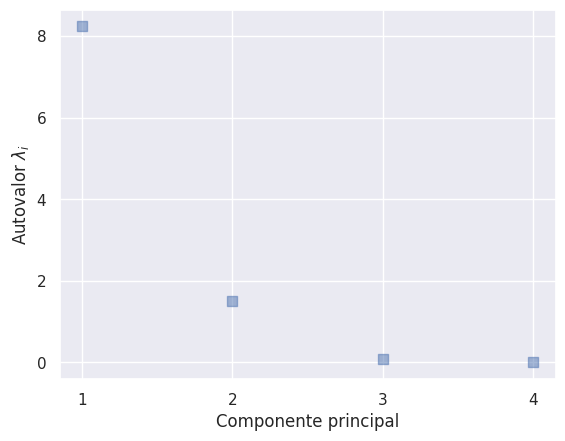

In [69]:
x_list = np.array(np.arange(1,m+1))
x_list = range(math.floor(min(x_list)), math.ceil(max(x_list))+1) # só para o gráfico mostrar inteiros no eixo x

plt.scatter(x_list, lambdai, marker ="s", s = 50,alpha=0.5)
plt.xlabel("Componente principal")
plt.ylabel("Autovalor "+r"$\lambda_i$")
plt.xticks(x_list)
plt.show()


### Exemplo bidimensional novamente

Voltemos ao exemplo bidimensional,

In [70]:
#Voltemos aos nossos dados aleatórios iniciais
m = 100
n = 2
np.random.seed(42)
x1 = 10.*np.sqrt((np.random.normal(size=m))**2)
x2 = x1 + 5.8*(np.random.normal(size=m))
X = np.stack((x1,x2),axis=1)


In [71]:
# calcula a média de cada coluna
xbar = np.mean(X, axis = 0).T
#gera um vetor de 1s
Vet1 = np.ones((m,1))
#subtrai de cada coluna de A sua respectiva média
Xc = X - np.outer(Vet1,xbar)
print(f'Primeiros 10 valores da Matriz A centralizada:\n {Xc[:10]}')


Primeiros 10 valores da Matriz A centralizada:
 [[ -2.26087942 -10.59939632]
 [ -5.84537793  -8.41448741]
 [ -0.75113556  -2.86824637]
 [  8.00227762   3.21970285]
 [ -4.8864872   -5.95131093]
 [ -4.88665138  -2.67252301]
 [  8.56410721  19.37461883]
 [  0.44632635   1.32951106]
 [ -2.53327709  -1.16885142]
 [ -1.80242051  -2.36357343]]


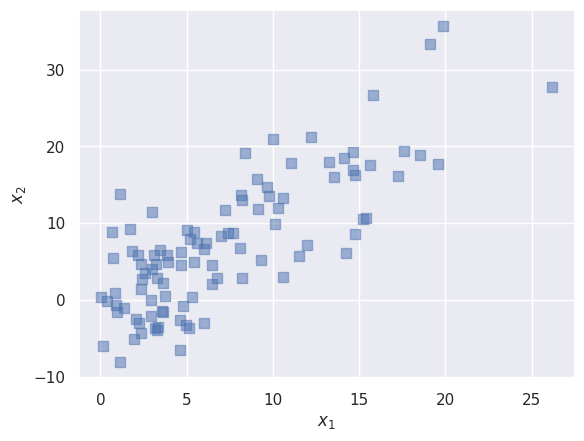

Variância x1 = 30.79428545290911
Variância x2 = 76.24938585795348


In [72]:
plt.scatter(x1, x2, marker ="s", s = 50,alpha=0.5)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()
print("Variância x1 =",np.var(x1,ddof=1))
print("Variância x2 =",np.var(x2,ddof=1))


In [73]:
U, sigmai, VT = np.linalg.svd(Xc)
Sigma =  np.diag(sigmai)
print(f'Matriz Diagonal com autovalores de A:\n {Sigma}')


Matriz Diagonal com autovalores de A:
 [[98.49495701  0.        ]
 [ 0.         29.93437662]]


ValueError: Masked arrays must be 1-D

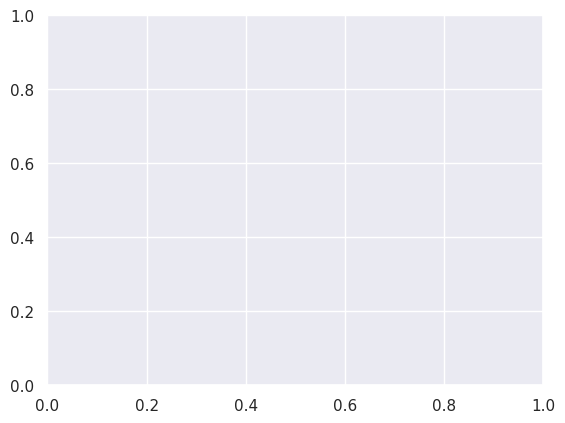

In [74]:
xaxis_title="CP-1"
yaxis_title="CP-2"
plt.scatter(Z[:,0], Z[:,1], marker ="s", s = 50,alpha=0.5)
plt.xlabel(xaxis_title)
plt.ylabel(yaxis_title)
plt.show()


Depois que as direções principais são calculadas, podemos projetar nossos dados como,

$$ \mathbf Z_{(m \times n)} = \mathbf X_{c{(m \times n)}} \mathbf V _ {(n \times n)}, $$

onde $ \mathbf V$ é a matriz das direções principais e  as colunas de $\mathbf Z$ definem as componentes principais.  Lembre-se: A j-ésima componente principal é dada pela j-ésima coluna de $\mathbf X_c \mathbf V $. As coordenadas do i-ésimo ponto de dados no novo espaço PC são dadas pela i-ésima linha de $\mathbf X_c \mathbf V $.


In [ ]:
cp = VT.T
Z = np.dot(Xc,cp)
print(f'Dimensão da matriz de projeção de Xc nas direções principais (componentes principais):\n{Z.shape}')


## Redução de dimensionalidade

Vamos reduzir a dimensão para "$k$". Observe na figura que basta selecionar os $k$ primeiros autovetores, ié, as $k$ primeiras colunas de $\mathbf V$.

A projeção $\mathbf z_i = \mathbf V^T\mathbf x_i$  pode ser escrita como a operação de matrizes:
$$
\mathbf Z_{(m,k)} = \mathbf X_{{(m,n)}}\mathbf V_{(n,k)}
$$

Portanto,
\begin{equation}
\mathbf V_{n,n} =
\begin{pmatrix}
|  & |  &   & |  \\
\mathbf v_{1} & \mathbf v_{2} & \cdots & \mathbf v_{k}\\
|  & |  &   & |
\end{pmatrix}
\end{equation}
de forma que:
\begin{equation}
\mathbf Z_{m,k} = \mathbf X_{m,n} \mathbf V_{n,k} =  
\begin{pmatrix}
{\mathbf x}_{1}\mathbf v_{1}& {\mathbf x}_{1} \mathbf v_{2}  & \cdots & {\mathbf x}_{1} \mathbf v_{k}\\
{\mathbf x}_{2}\mathbf v_{1}& {\mathbf x}_{2} \mathbf v_{2}  & \cdots & {\mathbf x}_{2} \mathbf v_{k}\\
\vdots  & \vdots  & \ddots & \vdots  \\
{\mathbf x}_{m}\mathbf v_{1}& {\mathbf x}_{m} \mathbf v_{2}  & \cdots & {\mathbf x}_{m} \mathbf v_{kn}\\
\end{pmatrix}
\end{equation}

A nova matriz $\mathbf Z$ pode ser definida como,

\begin{equation}
\mathbf Z_{m,k} =
\begin{pmatrix}
|  & |  &   & |  \\
\hat{\mathbf z}_{1} & \hat{\mathbf z}_{2} & \cdots & \hat{\mathbf z}_{k} \\
|  & |  &   & |  
\end{pmatrix}=
\begin{pmatrix}
-  & {\mathbf z}_{1}   & -  \\
 - & {\mathbf z}_{2}   & - \\
   & \vdots &    \\
 - & {\mathbf z}_{m} & -
\end{pmatrix}
\end{equation}
onde
\begin{equation}
\hat{\mathbf z}_i =
\begin{pmatrix}
{\mathbf x}_{1}\mathbf v_{i} \\
{\mathbf x}_{2}\mathbf v_{i} \\
\vdots   \\
{\mathbf x}_{m}\mathbf v_{i}
\end{pmatrix}
\end{equation}
é a transformação das observações na direção $\mathbf v_i$, e
\begin{equation}
{\mathbf z}_i =
\begin{pmatrix}
{\mathbf x}_{i}\mathbf v_{1} & {\mathbf x}_{i}\mathbf v_{2} & \cdots  & {\mathbf x}_{i}\mathbf v_{k}
\end{pmatrix}
\end{equation}
é a transformação da observação $i$.

In [ ]:
k = 1
Vk = cp[:,0:k]
Zk = np.dot(Xc,Vk)
print("Variância após a transformação",np.var(Zk, ddof = 1, axis=0))
print("Fração de variância capturada após a transformação: ",np.var(Zk,ddof = 1,axis=0)/np.sum(np.var(X_std, ddof =1, axis=0)))


Agora, vamos calcular a projeção inversa. Observe que as projeções podem ser escritas como $\mathbf z_i = \mathbf V^T \mathbf x_i$, portanto, a projeção inversa (re-projeção) pode ser escrita como
$$ \mathbf x^r_i = \mathbf {V}^{-1} \mathbf z_i = \mathbf {V}^{T} \mathbf z_i $$

Em forma de matrizes, temos
$$\mathbf X^r = \mathbf Z \mathbf V^T=\mathbf X \mathbf V \mathbf V^T$$



In [ ]:
Xr = np.dot(Zk,Vk.T)
print("Variância após a re-transformação",np.var(Xr, ddof = 1, axis=0))
# Plotar os dados
plt.figure(figsize=(8, 8))

# Plotar os dados X_std
plt.scatter(X_std[:, 0], X_std[:, 1], c='lightskyblue', marker='s', s=36, alpha=0.5, label='Dados X')

# Plotar os dados Xr
plt.scatter(Xr[:, 0], Xr[:, 1], c='cadetblue', s=64, alpha=0.8, label='Dados Xr')

for x, xr in zip(X_std, Xr):
    plt.plot([x[0], xr[0]], [x[1], xr[1]], 'DarkTurquoise', linestyle='dotted', linewidth=2)

plt.axis('equal')
plt.legend()
plt.title('Visualização dos Dados Originais e Reconstruídos')
plt.grid(True)
plt.show()


Para analisar os dados dentro de sua devida ordem de grandeza, deve-se transformar os dados normalizados **multiplicando pelo vetor de desvios padrão e adicionando o vetor da média**, ambos calculados anteriormente.
Calcule e plote os dados projetoados, agora não mais normalizados.

In [ ]:
Xm = np.mean(X,axis=0)
Xs = np.std(X,axis=0)

Xr = np.dot(Zk,Vk.T)*Xs+Xm

# Plotar os dados
plt.figure(figsize=(8, 8))

# Plotar os dados X
plt.scatter(X[:, 0], X[:, 1], c='lightskyblue', marker='s', s=36, alpha=0.5, label='Dados X')

# Plotar os dados Xr
plt.scatter(Xr[:, 0], Xr[:, 1], c='cadetblue', s=64, alpha=0.8, label='Dados Xr')

for x, xr in zip(X, Xr):
    plt.plot([x[0], xr[0]], [x[1], xr[1]], 'DarkTurquoise', linestyle='dotted', linewidth=2)

plt.axis('equal')
plt.legend()
plt.title('Visualização dos Dados Originais e Reconstruídos')
plt.grid(True)
plt.show()


# Classe PCA

In [ ]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance = None

    def fit(self, X):
        #1: Padronização dos dados (subtração da média)
        self.mean = np.mean(X, axis=0)
        Xc = X - self.mean

        #2: Cálculo das componentes principais
        U, sigmai, VT = np.linalg.svd(Xc)
        self.components = VT.T[:, :self.n_components]

        #3: Cálculo da variância explicada
        lambdai=sigmai**2/(len(U)-1)
        total_variance = np.sum(lambdai)
        self.explained_variance = lambdai[:self.n_components] / total_variance

    def transform(self, X):
        # Projeção dos dados nas componentes selecionadas
        Xc = X - self.mean
        Zk = np.dot(Xc, self.components)
        Xk = np.dot(Zk, self.components.T)
        return Zk,Xk

    def inverse_transform(self, Zk):
        # Reconstrução dos dados
        return np.dot(Xc, self.components)

    def get(self):
        return self.components, self.mean, self.explained_variance

    def plot_explained_variance(self):
        # Criação de rótulos para cada componente principal
        labels = [f'PCA{i+1}' for i in range(self.n_components)]

        # Criação de um gráfico de barras para variação explicada
        plt.figure(figsize=(8, 6))
        plt.bar(range(1, self.n_components + 1), self.explained_variance, alpha=0.7, align='center', color='blue', tick_label=labels)
        plt.xlabel('Componente Principal')
        plt.ylabel('Razão de Variância Explicada')
        plt.title('Variância explicada por componentes principais')
        plt.show()


In [75]:
m = 100
n = 2
np.random.seed(42)
x1 = 10.*np.sqrt((np.random.normal(size=m))**2)
x2 = x1 + 5.8*(np.random.normal(size=m))

X = np.stack((x1,x2),axis=1)
print(X.shape)


(100, 2)


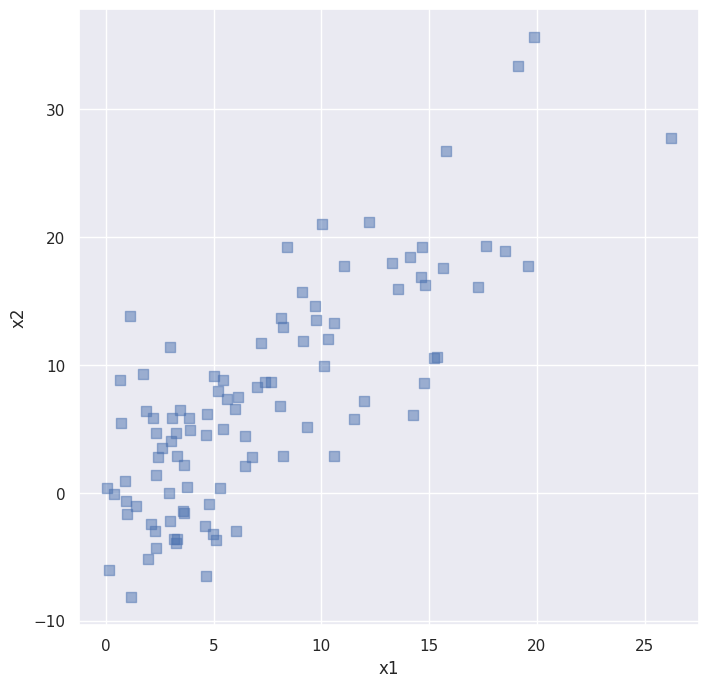

In [76]:
plt.figure(figsize=(8, 8))

plt.scatter(X[:,0], X[:,1], marker ="s", s = 50,alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


In [77]:
# PCA
pca = PCA(n_components=2)
pca.fit(X)

cps, meanX, explained_variance = pca.get()
print("Variância explicada:\n", explained_variance)
pca.plot_explained_variance()


AttributeError: 'PCA' object has no attribute 'get'

In [87]:
pca = PCA(n_components=1)
pca.fit(X)
cps, meanX, explained_variance = pca.get()
print("Variância explicada:\n", explained_variance)


AttributeError: 'PCA' object has no attribute 'get'

In [86]:
Xc = X - meanX
Zk, Xk = pca.transform(X)


plt.figure(figsize=(8, 8))
# Plotar os dados Xc
plt.scatter(Xc[:, 0], Xc[:, 1], c='lightskyblue', marker='s', s=36, alpha=0.5, label='Dados X')

# Plotar os dados Xk
plt.scatter(Xk[:, 0], Xk[:, 1], c='cadetblue', s=64, alpha=0.8, label='Dados Xk')

for x, xk in zip(Xc, Xk):
    plt.plot([x[0], xk[0]], [x[1], xk[1]], 'DarkTurquoise', linestyle='dotted', linewidth=2)

plt.axis('equal')
plt.legend()
plt.title('Visualização dos Dados Originais e Reconstruídos')
plt.grid(True)
plt.show()


NameError: name 'meanX' is not defined

Um exemplo 3D...

In [78]:
m = 100
n = 3
np.random.seed(42)
x1 = 10.*np.sqrt((np.random.normal(size=m))**2)
x2 = x1 + 5.8*(np.random.normal(size=m))
x3 = x1 + 10.*np.sqrt((np.random.normal(size=m))**2)
X = np.stack((x1,x2,x3),axis=1)
print(X.shape)


(100, 3)


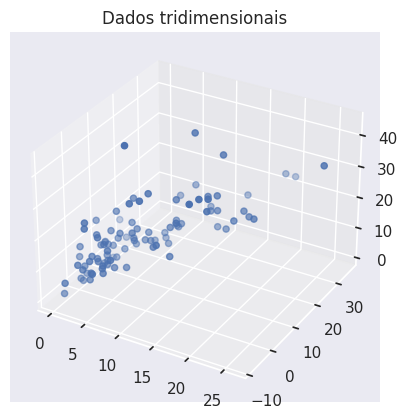

In [79]:
fig = plt.figure()


ax = plt.axes(projection ='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], 'green')
ax.set_title('Dados tridimensionais')
plt.show()


In [80]:
pca = PCA(n_components=1)
pca.fit(X)
cps, meanX, explained_variance = pca.get()
print("Variância explicada:\n", explained_variance)


AttributeError: 'PCA' object has no attribute 'get'

In [81]:
Xc = X - meanX
Zk, Xk = pca.transform(X)


NameError: name 'meanX' is not defined

IndexError: index 2 is out of bounds for axis 1 with size 2

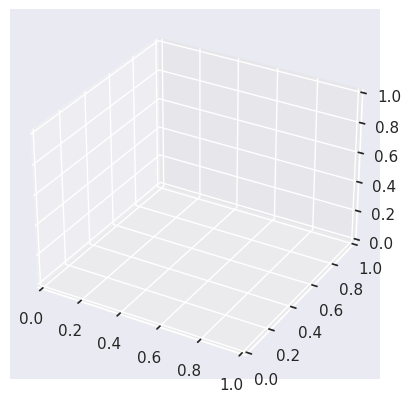

In [82]:
fig = plt.figure()


ax = plt.axes(projection ='3d')
ax.scatter(Xc[:,0], Xc[:,1], Xc[:,2], label='Dados Xc')
plt.scatter(Xk[:, 0], Xk[:, 1], c='cadetblue', s=30, alpha=0.8, label='Dados Xk')
ax.set_title('Dados tridimensionais')
ax.view_init(elev=90., azim=180)
plt.show()


In [83]:
pca = PCA(n_components=2)
pca.fit(X)
cps, meanX, explained_variance = pca.get()
print("Variância explicada:\n", explained_variance)
pca.plot_explained_variance()


AttributeError: 'PCA' object has no attribute 'get'

In [84]:
Xc = X - meanX
Zk, Xk = pca.transform(X)


NameError: name 'meanX' is not defined

IndexError: index 2 is out of bounds for axis 1 with size 2

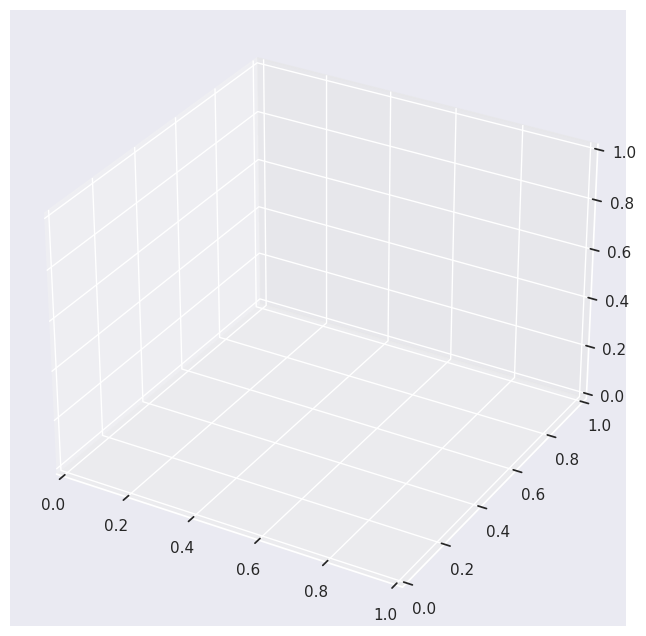

In [85]:
fig = plt.figure(figsize=(8, 8))

ax = plt.axes(projection ='3d')
ax.scatter(Xc[:,0], Xc[:,1], Xc[:,2], c= 'navy', label='Dados Xc')
ax.plot_trisurf(Xk[:,0], Xk[:,1], Xk[:,2],  alpha=0.8, linewidth=0, edgecolor='none')
ax.set_title('Dados tridimensionais')
ax.view_init(elev=30., azim=40)
plt.show()


# Seus estudos

1. Explique as direções principais (em azul) das imagens Parte I e construa as componentes principais da Parte II.

<center><img src='https://drive.google.com/uc?export=view&id=1pgmLj0XGXOegBmAd6YJfmZn0DuAE77Yi' width="800"></center>


2. __What influences love at first sight?__ A partir de dados disponível no Kaggle e compilado por professores da Columbia Business School, quando tentavam encontrar uma resposta para a pergunta O que influencia o amor à primeira vista? , aplique PCA e tire conclusões relevantes sobre o tema.
Os dados foram coletados de participantes em eventos experimentais de speed dating de 2002 a 2004.

<center><img src='https://drive.google.com/uc?export=view&id=1e_uFYG37Xjz5JJsq3tC3kLoWenrg6jo6' width="400"></center>